# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131
## Данный скрипт реализует ранжирование игроков по ролям внутри команды на основе вклада в победу, используя информацию на конец матча (важен порядок, но не абсолютные значения показателей).

### TODO: Для роли Carry модель выдает заниженные результаты.
### Role:
###### 1 - Carry
###### 2 - Mid
###### 3 - Hard-lane
###### 4 - Semi-support
###### 5 - Full-support

### Взаимодействие с Dotabuff:
###### Информация об игроке: https://www.dotabuff.com/esports/players/<'account_id'>

###### Информация о матче: https://www.dotabuff.com/matches/<'match_id'>

###### Информация о команде: https://www.dotabuff.com/esports/teams/<'team_id'>

#### В таблице "Matches & Contributions.csv" представлены матчи за период с 03.03.2017 по 30.04.2017

In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import requests
from datetime import datetime
import time
from requests.auth import HTTPBasicAuth
import sys
import io
import datetime
import math 
import sklearn 
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [3]:
def download_google_spreadsheet(url):
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        content_bytes = resp.content
    except requests.exceptions.HTTPError as err:
        print(err, file=sys.stderr)
    try:
        content = pd.read_csv(io.BytesIO(content_bytes))
        return content
    except Exception as err:
        print("failed to convert bytes to csv:", err, file=sys.stderr)

In [4]:
def query_opendota(sql):
    resp = requests.get('https://api.opendota.com/api/explorer', params={'sql': sql})
    data = resp.json()
    if resp.status_code == 400 and data is not None:
        sys.stderr.write(data['err'])
    resp.raise_for_status()
    return pd.DataFrame.from_records(data['rows'])

In [5]:
player_role = download_google_spreadsheet('https://docs.google.com/spreadsheets/d/e/2PACX-1vRV7SmVCA3a-IgxDRmhEJjFwLner7tEgRXHy_gcgav7GF2pCv4bOlwwt6B8RHkBP8LxV6Idf3zVVnze/pub?output=csv')

# Data Import

In [6]:
sdf_1 = pd.read_csv('ScoresByRole_1.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_2 = pd.read_csv('ScoresByRole_2.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_3 = pd.read_csv('ScoresByRole_3.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_4 = pd.read_csv('ScoresByRole_4.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_5 = pd.read_csv('ScoresByRole_5.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })

In [7]:
sdf = pd.concat([sdf_1, sdf_2, sdf_3, sdf_4, sdf_5])

In [8]:
matches = sdf.sort_values(by = ['match_id', 'team_id', 'role'], ascending = False)

In [9]:
# matches

# Cumulative Score (match_id + team_id)

In [10]:
cumprob = matches.groupby(['match_id', 'team_id'], as_index=False)['win_prob'].sum()
cumprob.rename(columns = {'win_prob' : 'cumulative_prob'}, inplace = True)

In [11]:
cumprob.sort_values(by = ['match_id', 'cumulative_prob'], ascending = False, inplace = True)
# cumprob

In [12]:
matches = pd.merge(matches, cumprob, on=['match_id', 'team_id'], how='inner')
matches.rename(columns = {'win_prob_x' : 'win_prob', 'win_prob_y' : 'cumulative_prob'}, inplace = True)

In [13]:
matches['win_contribution'] = matches['win_prob'] / matches['cumulative_prob']

In [14]:
# matches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

In [15]:
matchesFreq = matches.groupby(['match_id'])['match_id'].count()

In [16]:
len(matchesFreq)

359

#### Избавимся от матчей, которые представлены менее чем 10 записями

In [17]:
fullMatches = matchesFreq[matchesFreq == 10]
len(fullMatches)

116

In [18]:
isFull = np.in1d(matches['match_id'], fullMatches.index.values)

In [19]:
len(isFull)

2541

In [20]:
matches['isFull'] = isFull

In [21]:
sMatches = matches[matches['isFull'] == True]

# Финальная таблица
## Описание полей:
account_id - Идентификатор игрока

match_id - Идентификатор матча

team_id - Идентификатор команды

role - Исполняемая роль (Описание См. Выше)

datetime - Дата окончания матча

win - Идентификатор победы (Целевая переменная)

win_prob - Предсказанная вероятность победы на основе информации по игроку данной роли

prediction - Предсказание со стандартным порогом отсечения (True if win_prob >= 0.5)

isCorrect - Флаг совпадения предсказания с реальностью

cumulative_prob - Сумма вероятностей победы по команде в матче

win_contribution - Вклад игрока данной роли в победу (win_prob / cumulative_prob)

isFull - Флаг того, что для данного match_id в таблице имеется ровно 10 записей (по 5 на команду)

In [22]:
sMatches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

account_id    match_id    team_id role             datetime    win  \
3     105248644  3372726385     2163.0  2.0  13.08.2017 03:12:57   True   
2      34505203  3372726385     2163.0  3.0  13.08.2017 03:12:57   True   
4      72312627  3372726385     2163.0  1.0  13.08.2017 03:12:57   True   
1     101356886  3372726385     2163.0  4.0  13.08.2017 03:12:57   True   
0      82262664  3372726385     2163.0  5.0  13.08.2017 03:12:57   True   
9      82327674  3372726385  1375614.0  1.0  13.08.2017 03:12:57  False   
8      87012746  3372726385  1375614.0  2.0  13.08.2017 03:12:57  False   
7     149486894  3372726385  1375614.0  3.0  13.08.2017 03:12:57  False   
5     117281554  3372726385  1375614.0  5.0  13.08.2017 03:12:57  False   
6     139876032  3372726385  1375614.0  4.0  13.08.2017 03:12:57  False   
13    105248644  3372676225     2163.0  2.0  13.08.2017 02:13:08   True   
12     34505203  3372676225     2163.0  3.0  13.08.2017 02:13:08   True   
11    101356886  3372676225     2163.0  4.0  13.08.2017 02:13:08   True   
14     72312627  3372676225     2163.0  1.0  13.08.2017 02:13:08   True   
10     82262664  3372676225     2163.0  5.0  13.08.2017 02:13:08   True   
17    149486894  3372676225  1375614.0  3.0  13.08.2017 02:13:08  False   
15    117281554  3372676225  1375614.0  5.0  13.08.2017 02:13:08  False   
19     82327674  3372676225  1375614.0  1.0  13.08.2017 02:13:08  False   
16    139876032  3372676225  1375614.0  4.0  13.08.2017 02:13:08  False   
18     87012746  3372676225  1375614.0  2.0  13.08.2017 02:13:08  False   
24     72312627  3372622939     2163.0  1.0  13.08.2017 01:17:48   True   
22     34505203  3372622939     2163.0  3.0  13.08.2017 01:17:48   True   
21    101356886  3372622939     2163.0  4.0  13.08.2017 01:17:48   True   
20     82262664  3372622939     2163.0  5.0  13.08.2017 01:17:48   True   
23    105248644  3372622939     2163.0  2.0  13.08.2017 01:17:48   True   
27    149486894  3372622939  1375614.0  3.0  13.08.2017 01:17:48  False   
29     82327674  3372622939  1375614.0  1.0  13.08.2017 01:17:48  False   
25    117281554  3372622939  1375614.0  5.0  13.08.2017 01:17:48  False   
26    139876032  3372622939  1375614.0  4.0  13.08.2017 01:17:48  False   
28     87012746  3372622939  1375614.0  2.0  13.08.2017 01:17:48  False   
...         ...         ...        ...  ...                  ...    ...   
2250   90882159  3277141049  3331948.0  2.0  27.06.2017 14:09:39  False   
2251  148215639  3277141049  3331948.0  1.0  27.06.2017 14:09:39  False   
2249  111189717  3277141049  3331948.0  3.0  27.06.2017 14:09:39  False   
2248  119576842  3277141049  3331948.0  4.0  27.06.2017 14:09:39  False   
2247  114239371  3277141049  3331948.0  5.0  27.06.2017 14:09:39  False   
2255  173880329  3277141049  2640025.0  2.0  27.06.2017 14:09:39   True   
2256  137193239  3277141049  2640025.0  1.0  27.06.2017 14:09:39   True   
2254  111291593  3277141049  2640025.0  3.0  27.06.2017 14:09:39   True   
2252  103940975  3277141049  2640025.0  5.0  27.06.2017 14:09:39   True   
2253  103039499  3277141049  2640025.0  4.0  27.06.2017 14:09:39   True   
2302  192914280  3276779761  2581813.0  3.0  27.06.2017 10:36:11  False   
2304  180012313  3276779761  2581813.0  1.0  27.06.2017 10:36:11  False   
2301  323792491  3276779761  2581813.0  4.0  27.06.2017 10:36:11  False   
2300   91654584  3276779761  2581813.0  5.0  27.06.2017 10:36:11  False   
2303  122867857  3276779761  2581813.0  2.0  27.06.2017 10:36:11  False   
2308  184950344  3276779761  2108395.0  2.0  27.06.2017 10:36:11   True   
2309  132309493  3276779761  2108395.0  1.0  27.06.2017 10:36:11   True   
2305   87196890  3276779761  2108395.0  5.0  27.06.2017 10:36:11   True   
2306  155494381  3276779761  2108395.0  4.0  27.06.2017 10:36:11   True   
2307  187619311  3276779761  2108395.0  3.0  27.06.2017 10:36:11   True   
2531   93119769  3274393974  3931002.0  2.0  26.06.2017 06:01:32   True   
2532  102099826  3274393974   

In [23]:
sMatches.to_csv('Matches & Contributions.csv', index = False, na_rep = 'NaN', sep = ';')

# Plots

In [24]:
ti_main = [
     3362113115,
     3362175204,
     3362247584,
     3362331228,
     3362390555,
     3362458643,
     3362526195,
     3362609879,
     3362675038,
     3363973439,
     3364084016,
     3364162010,
     3364210383,
     3364267872,
     3364308762,
     3364351128,
     3364409216,
     3364482110,
     3365858882,
     3365946637,
     3366042233,
     3366096005,
     3366166505,
     3366236403,
     3366289447,
     3366363258,
     3366419778,
     3367820228,
     3367897602,
     3367983348,
     3368083254,
     3368158118,
     3368249009,
     3368300783,
     3368387319,
     3369858045,
     3369930606,
     3370054178,
     3370154221,
     3370213472,
     3370307979,
     3370363807,
     3372269708,
     3372386596,
     3372455628,
     3372622939,
     3372676225,
     3372726385
]

<IPython.core.display.Javascript object>


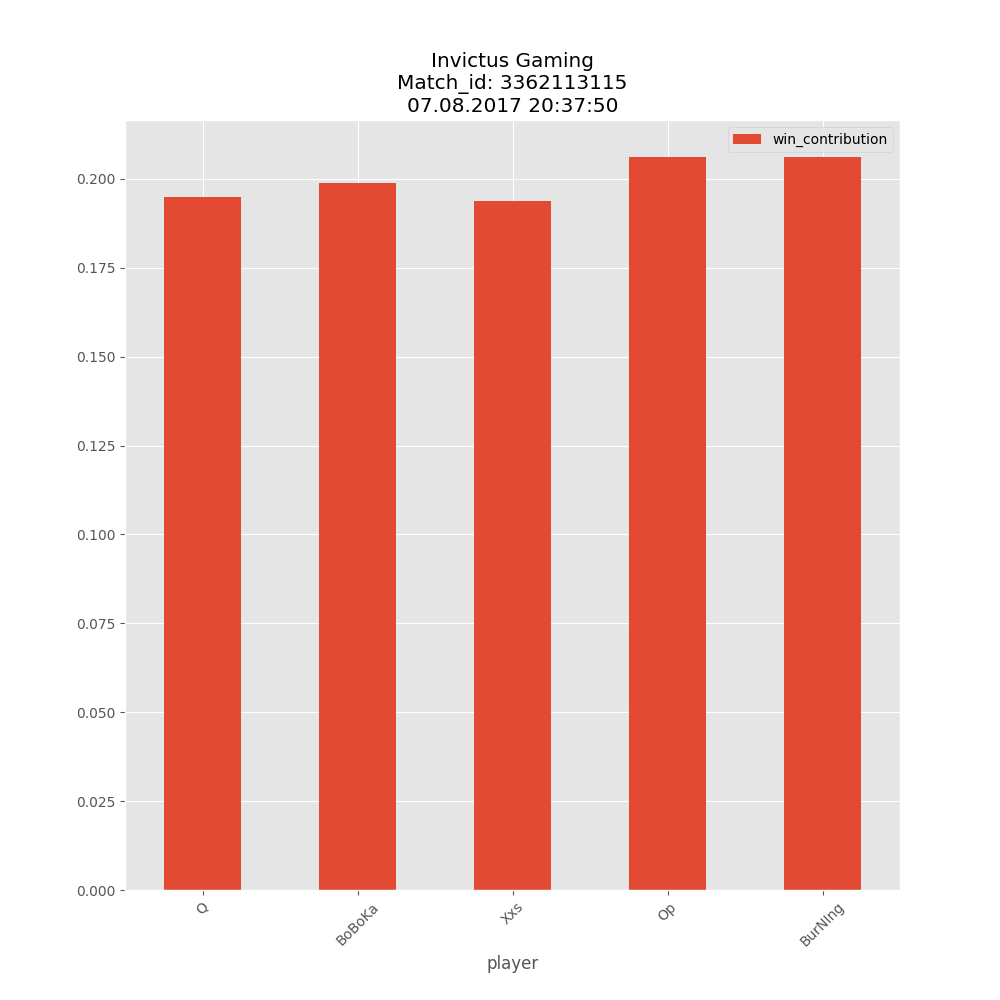

<IPython.core.display.Javascript object>


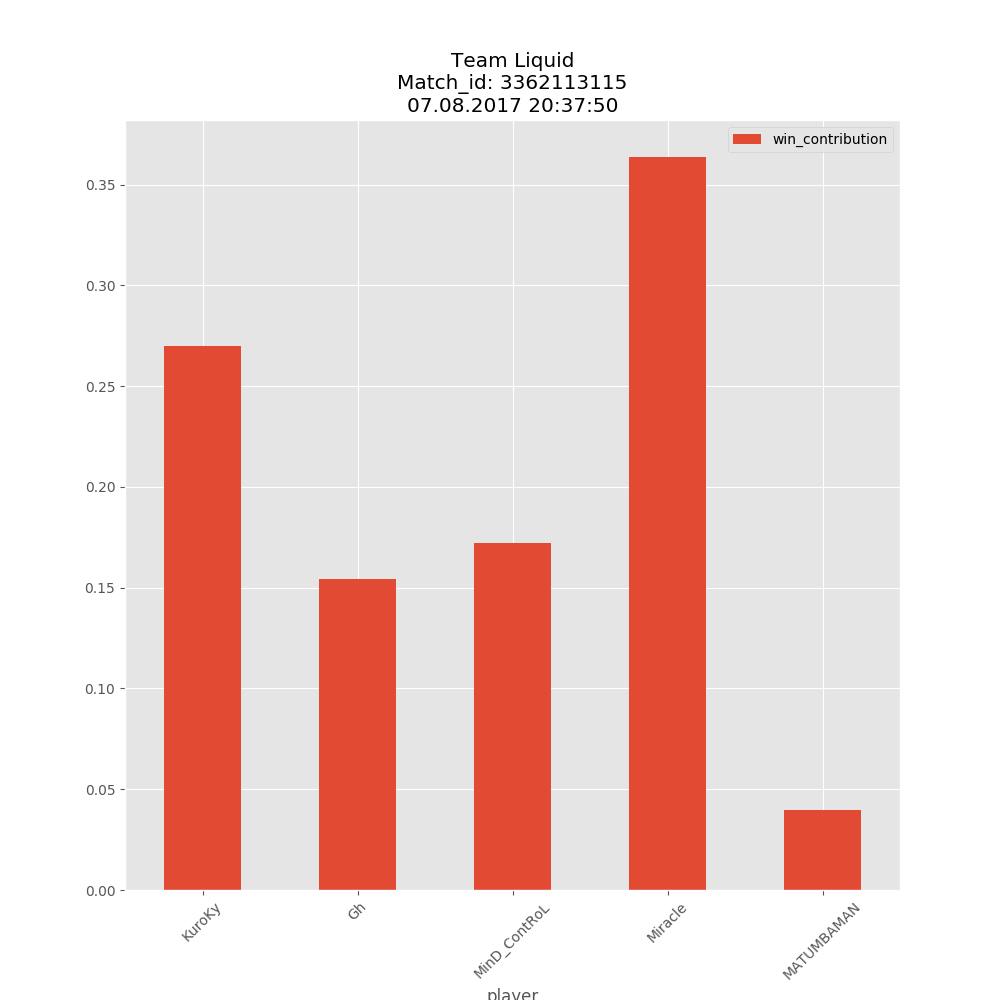

<IPython.core.display.Javascript object>


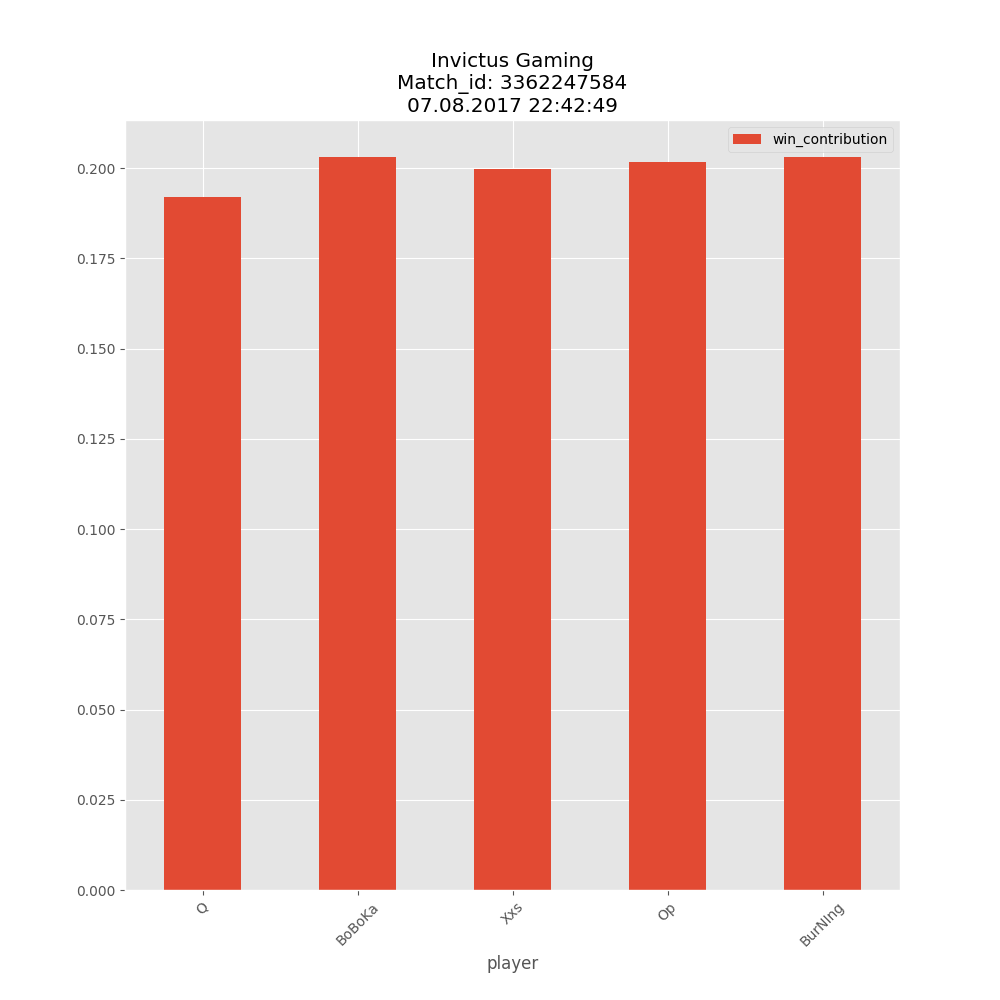

<IPython.core.display.Javascript object>


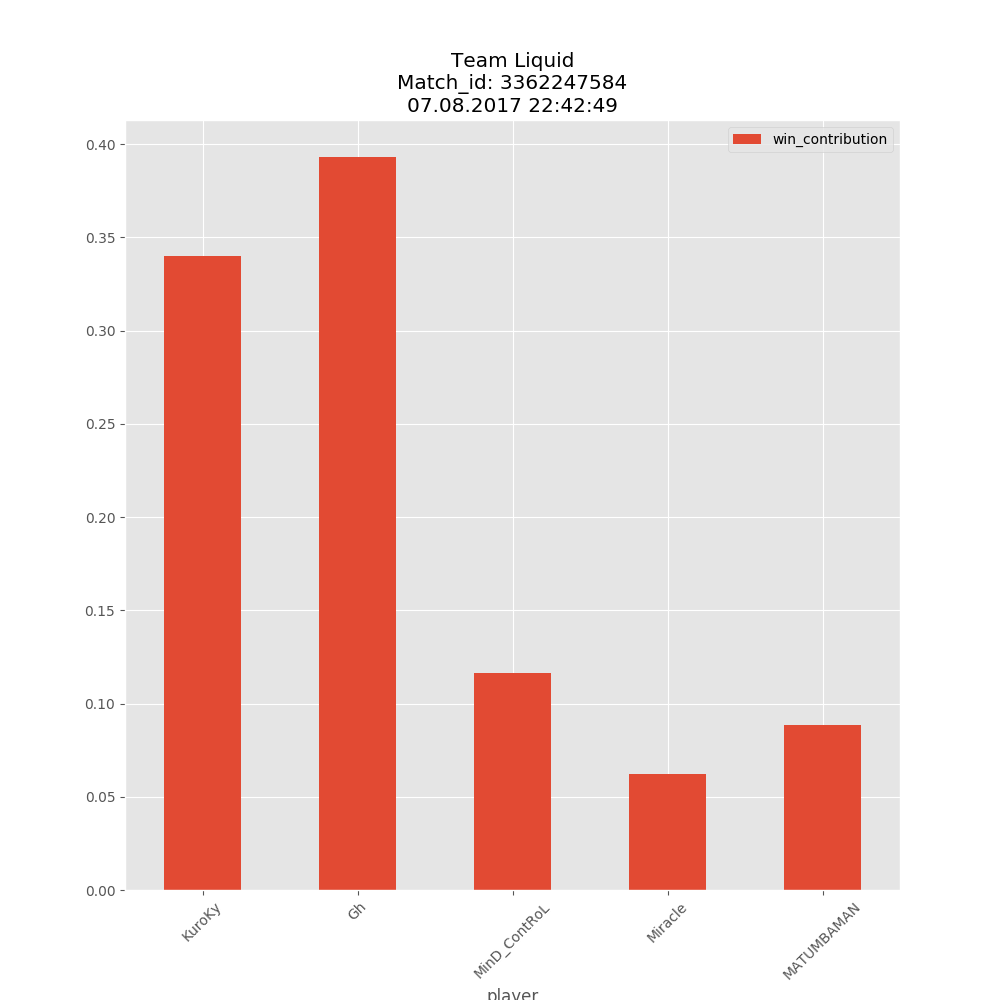

<IPython.core.display.Javascript object>


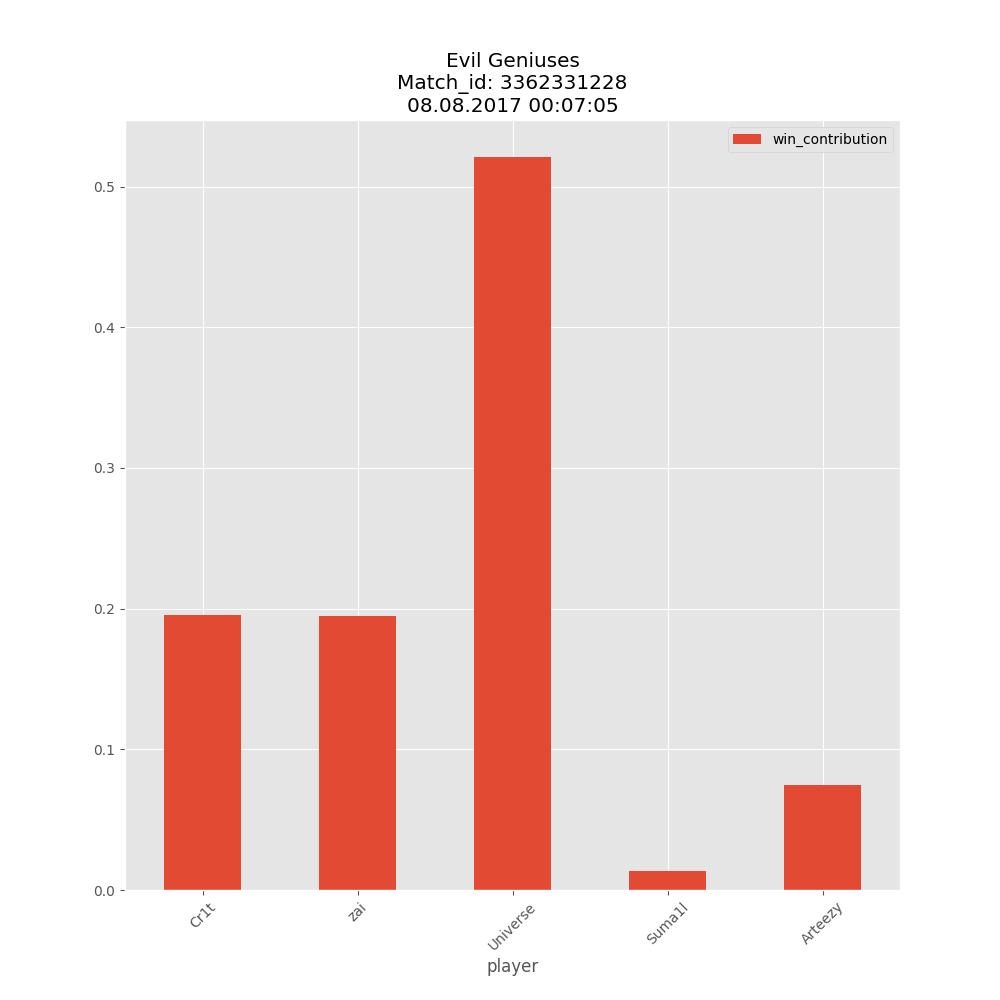

<IPython.core.display.Javascript object>


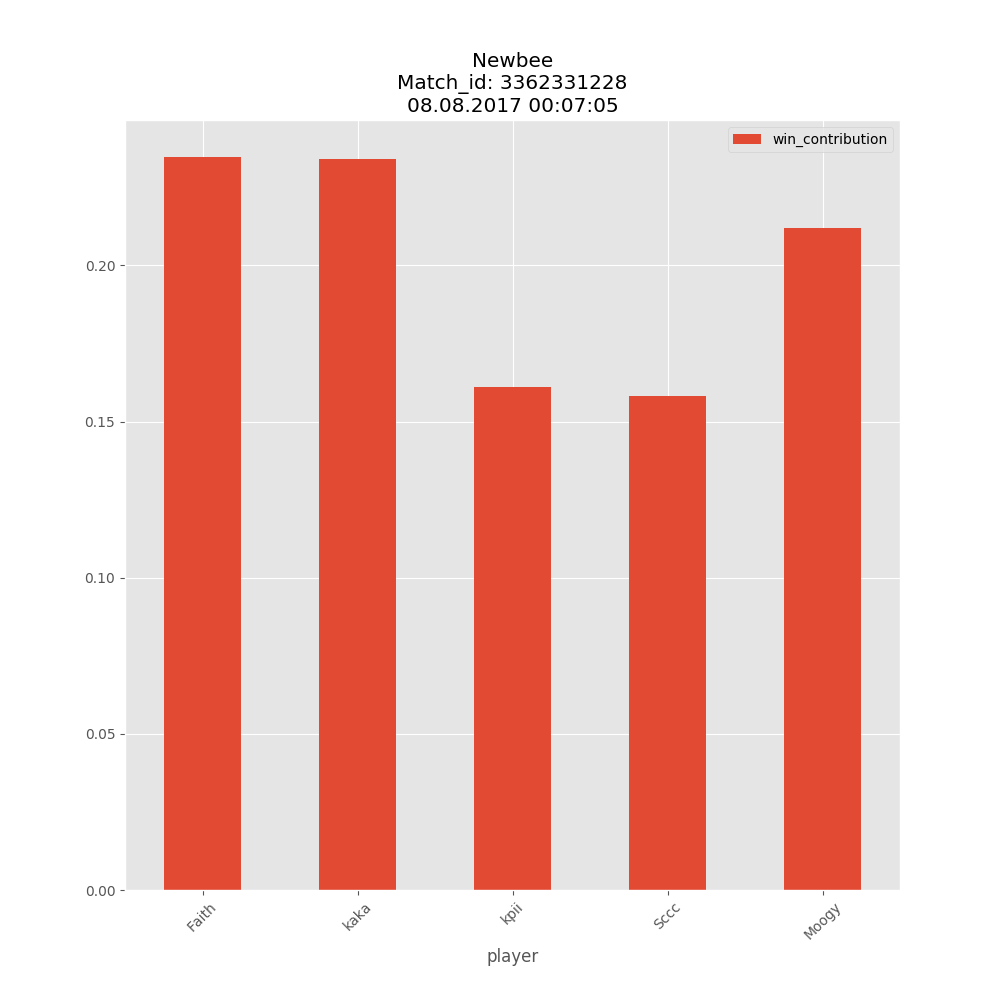

<IPython.core.display.Javascript object>


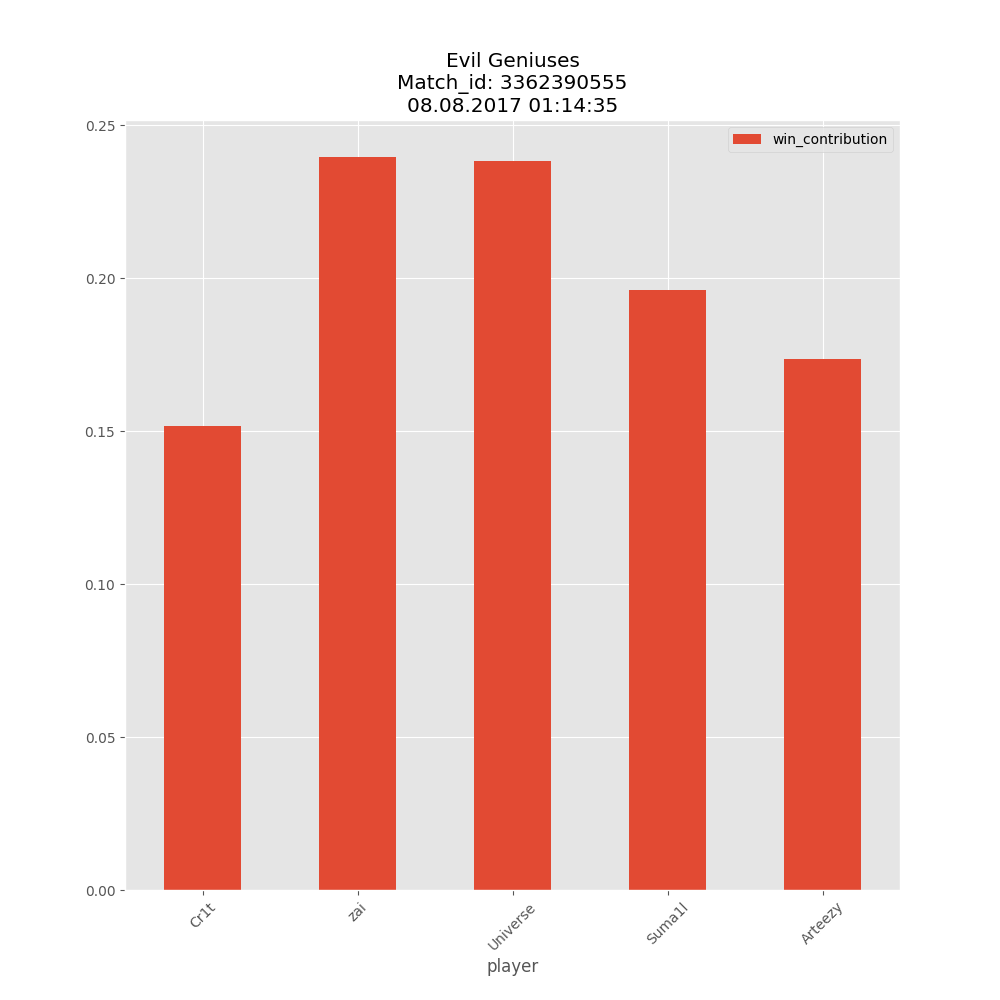

<IPython.core.display.Javascript object>


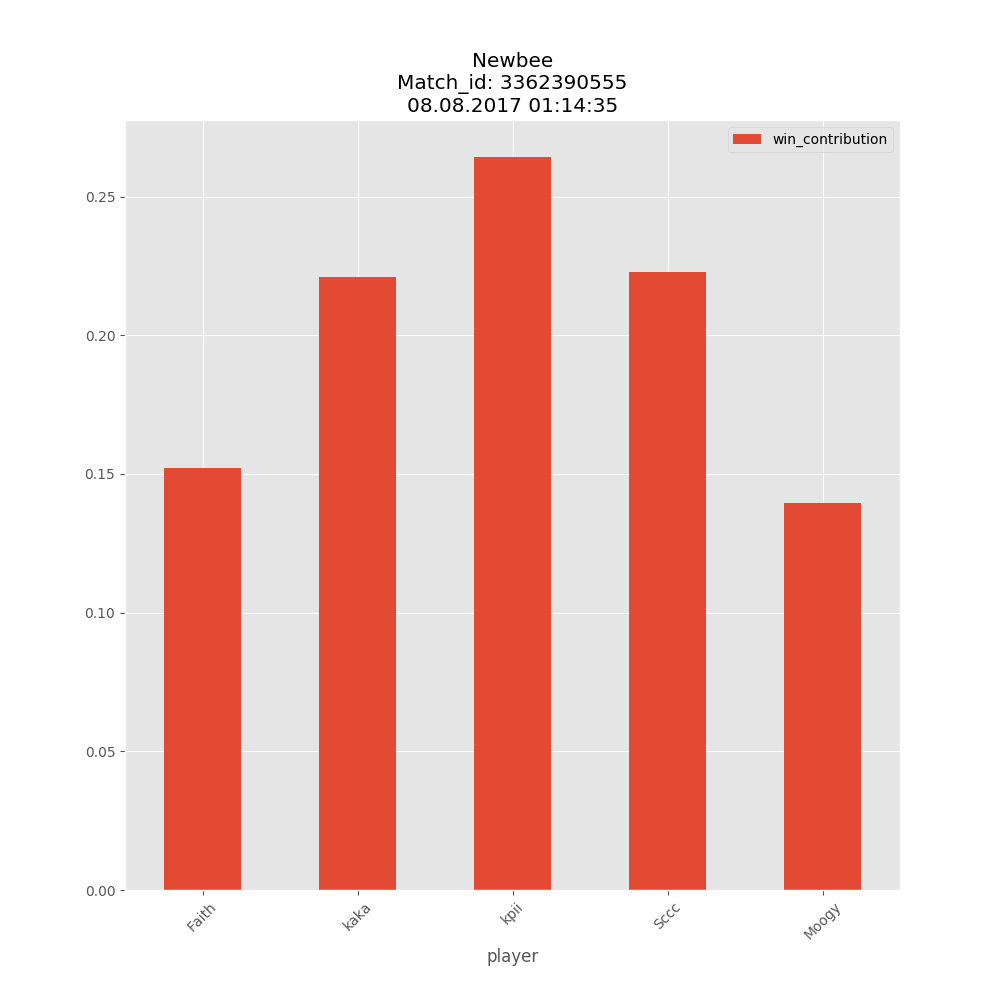

<IPython.core.display.Javascript object>


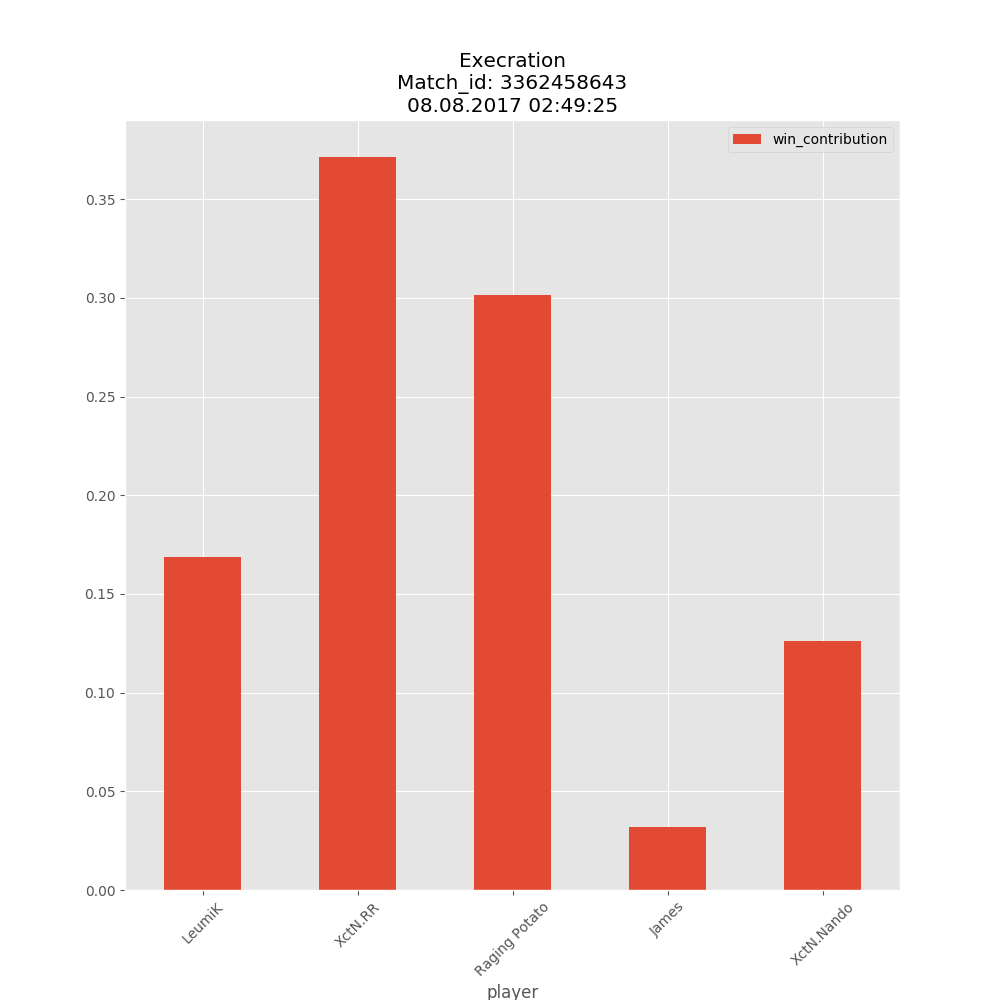

<IPython.core.display.Javascript object>


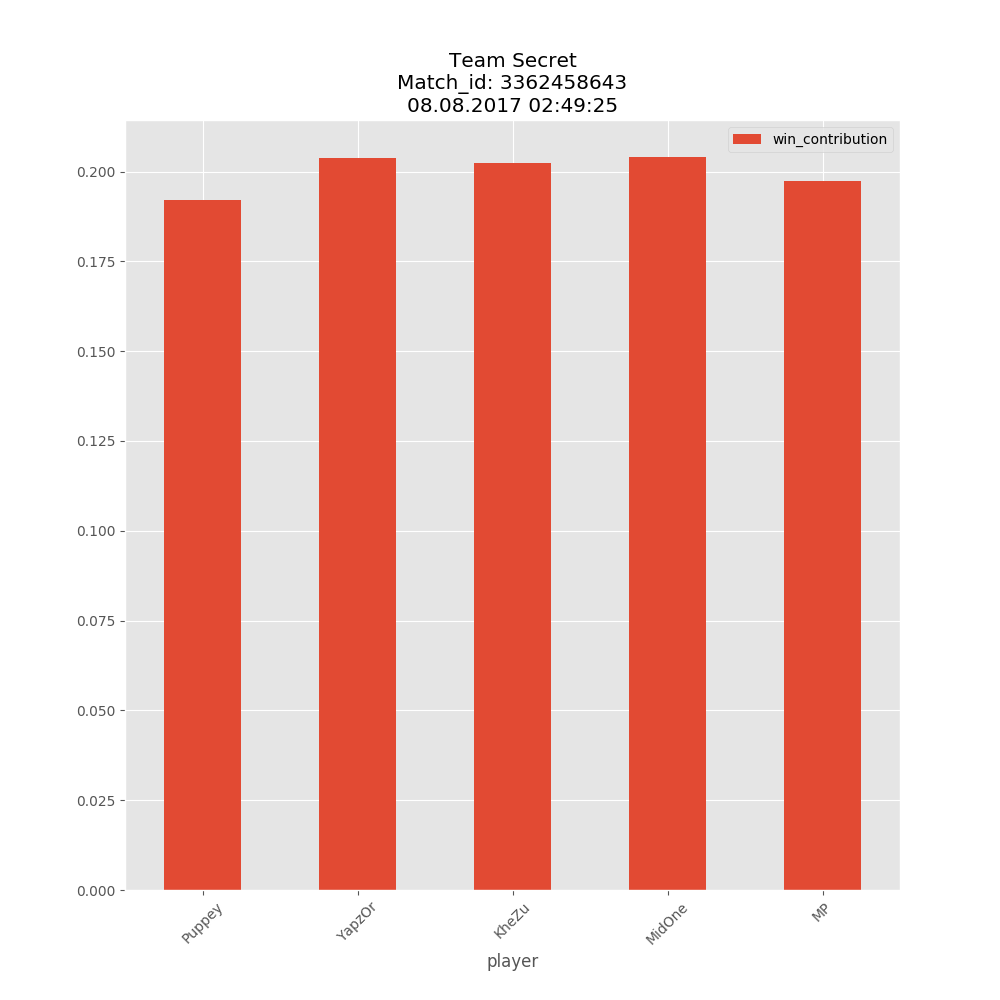

<IPython.core.display.Javascript object>


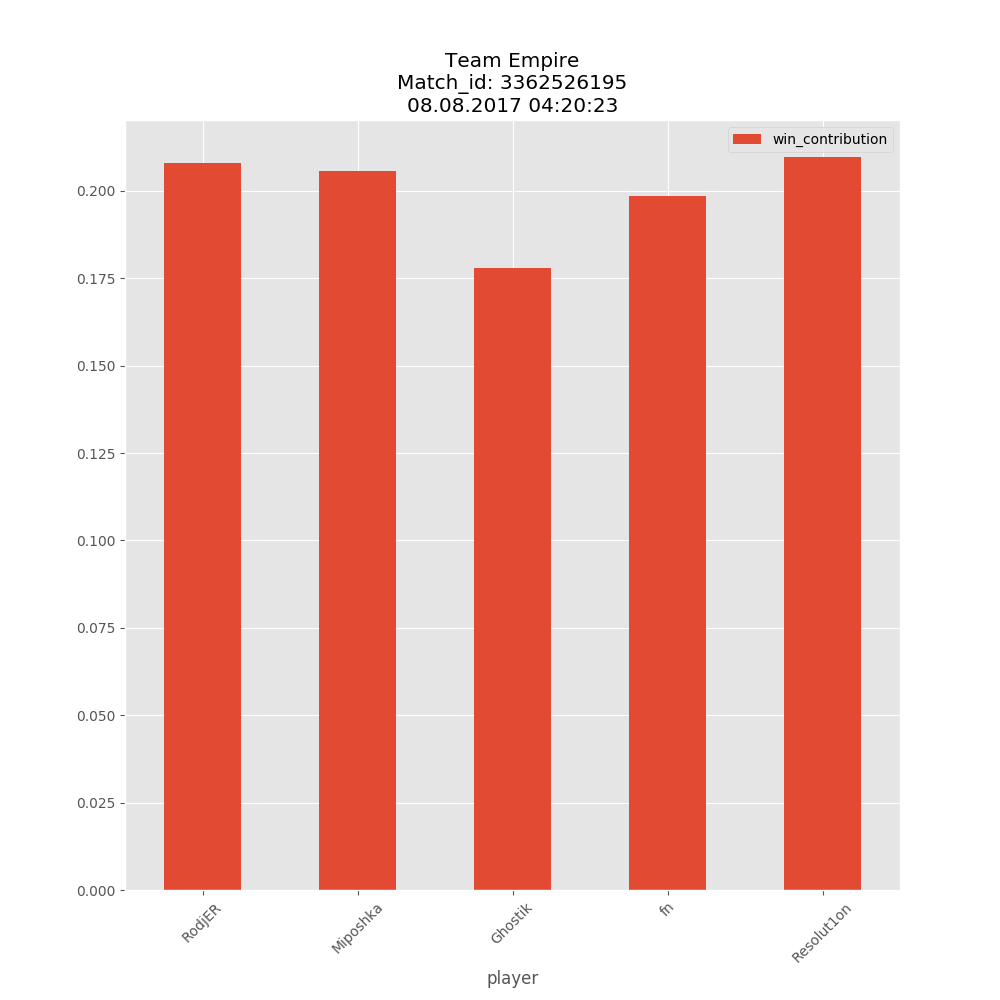

<IPython.core.display.Javascript object>


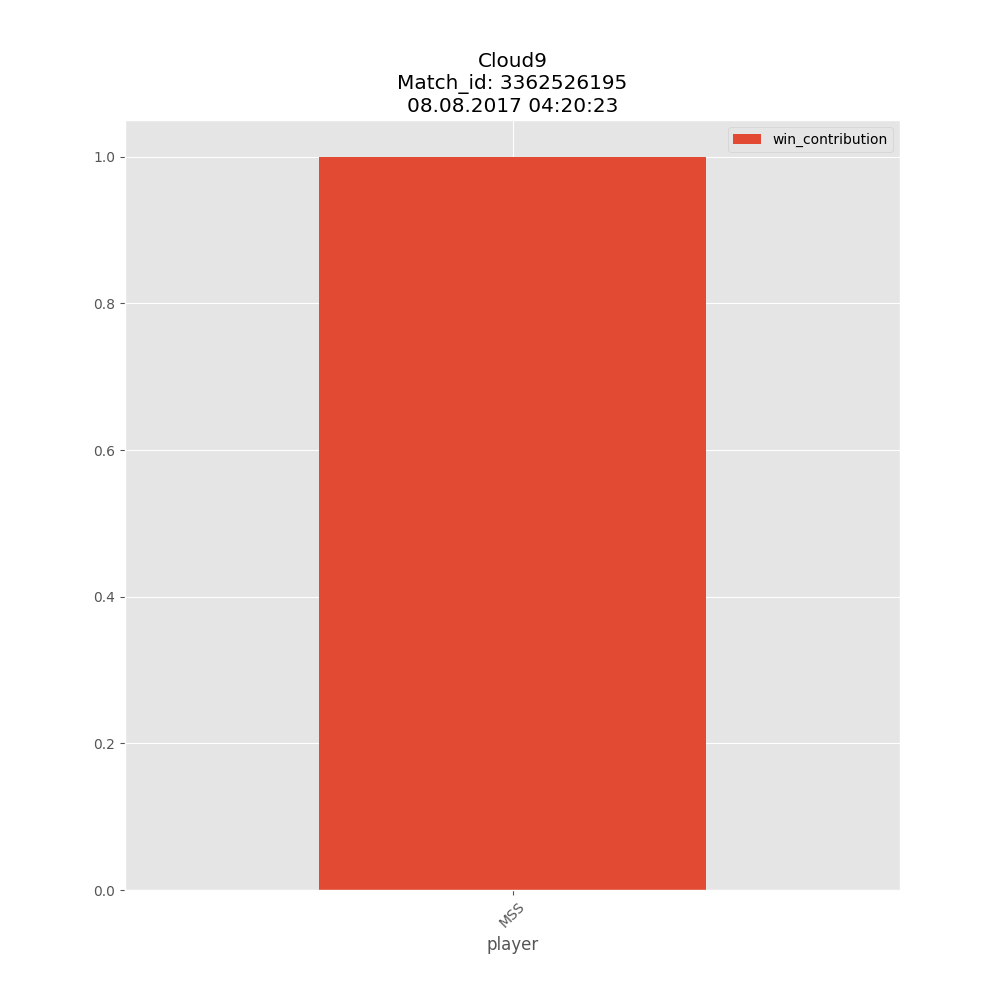

<IPython.core.display.Javascript object>


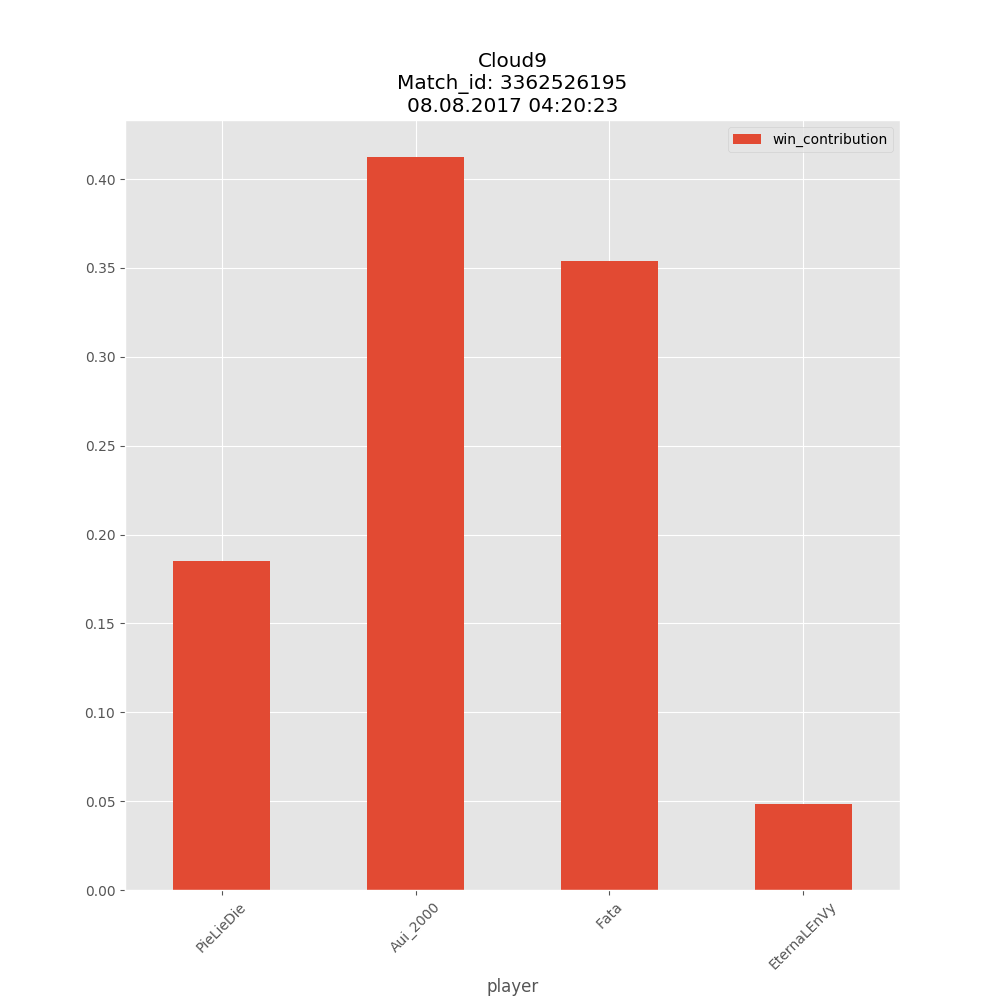

<IPython.core.display.Javascript object>


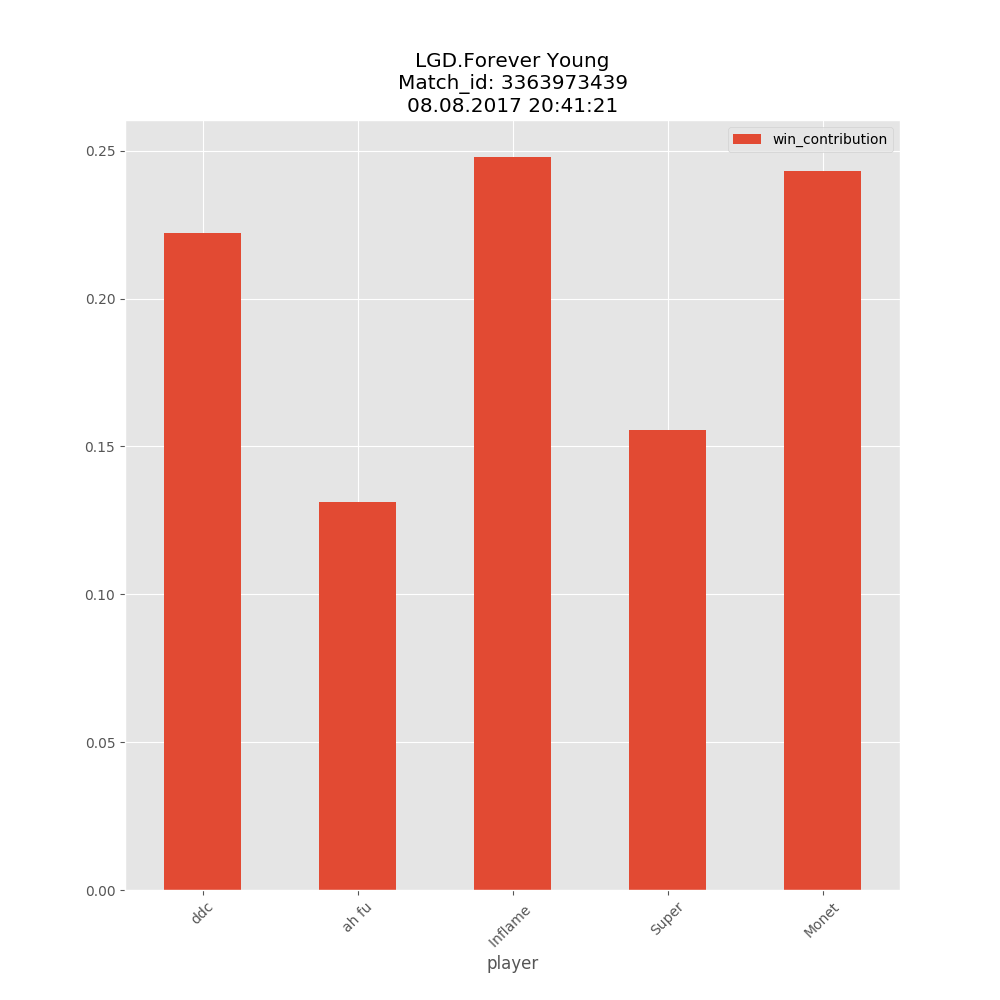

<IPython.core.display.Javascript object>


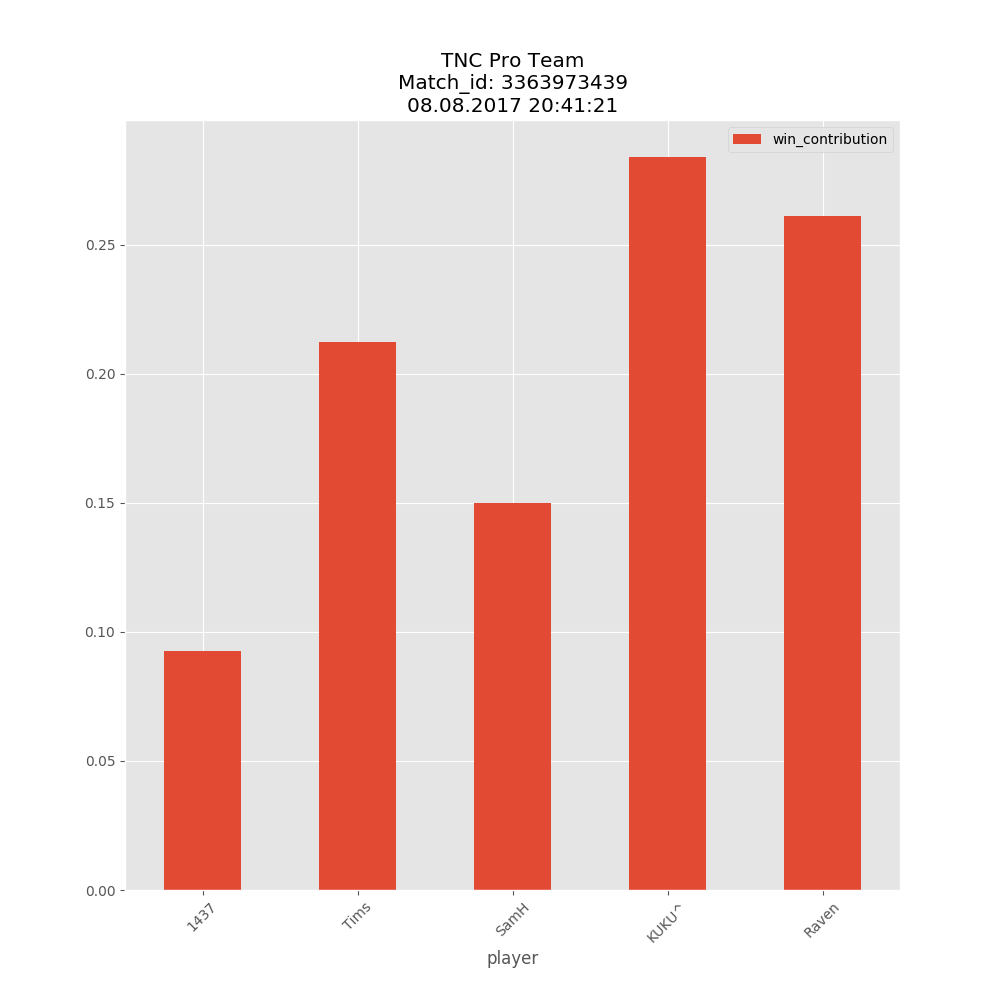

<IPython.core.display.Javascript object>


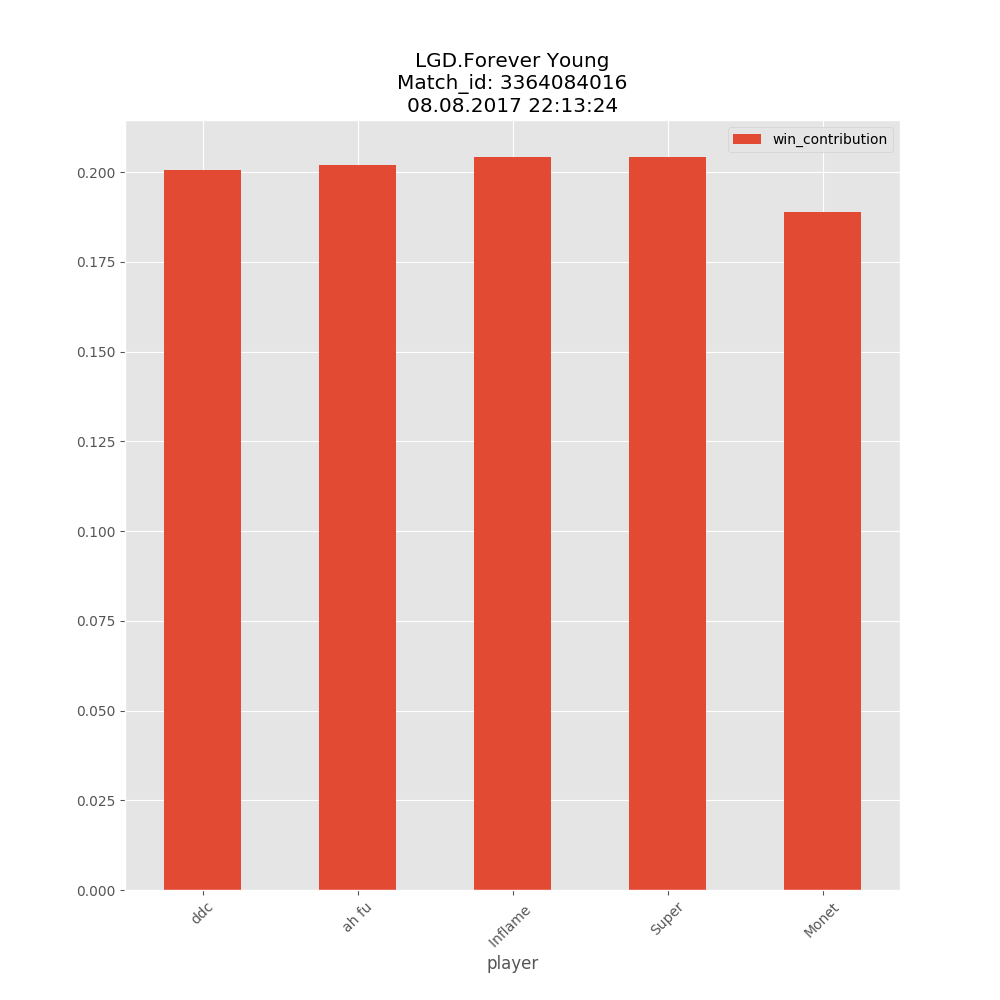

<IPython.core.display.Javascript object>


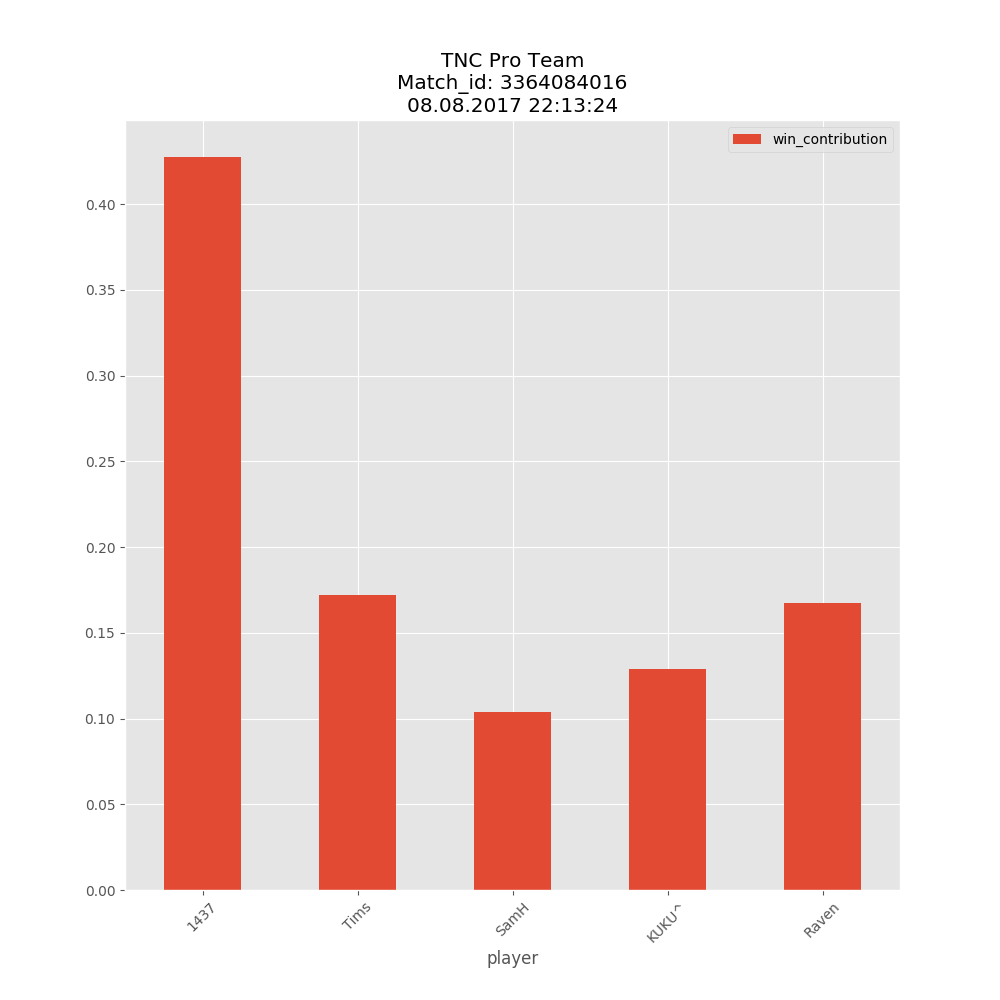

<IPython.core.display.Javascript object>


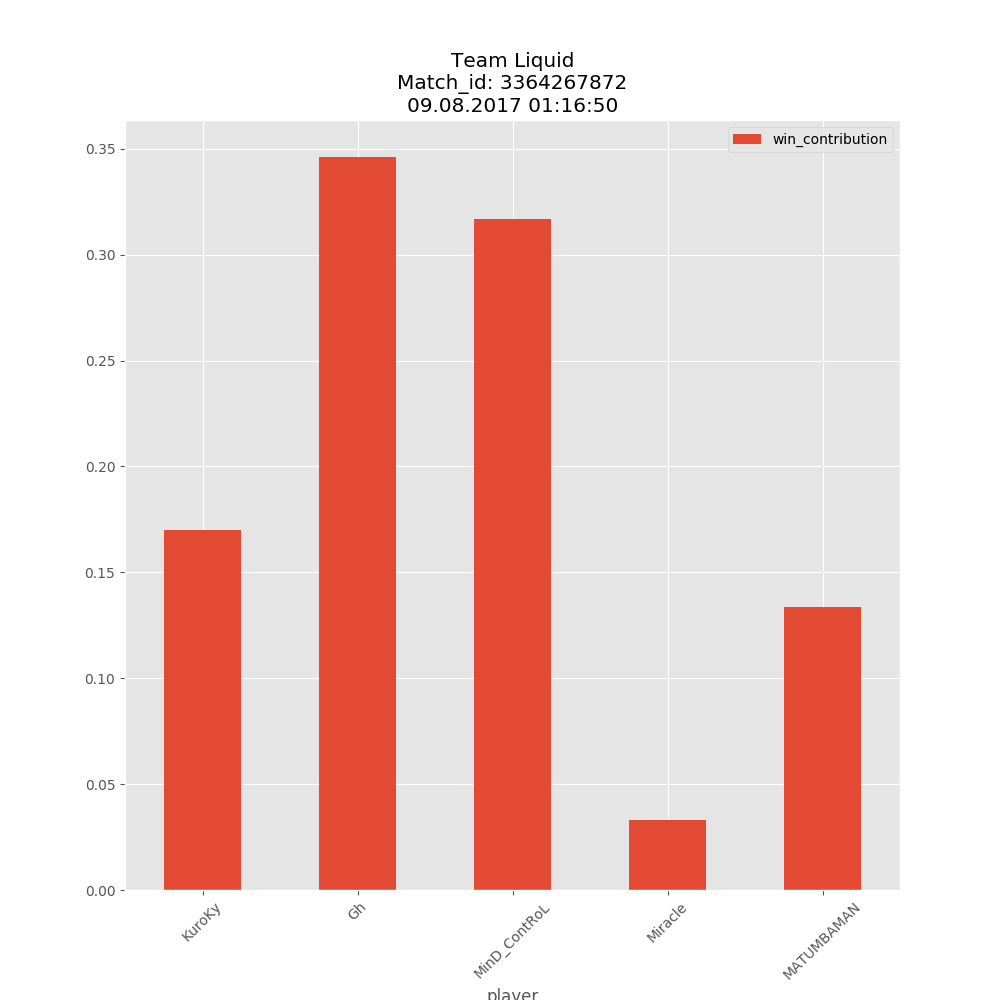

<IPython.core.display.Javascript object>


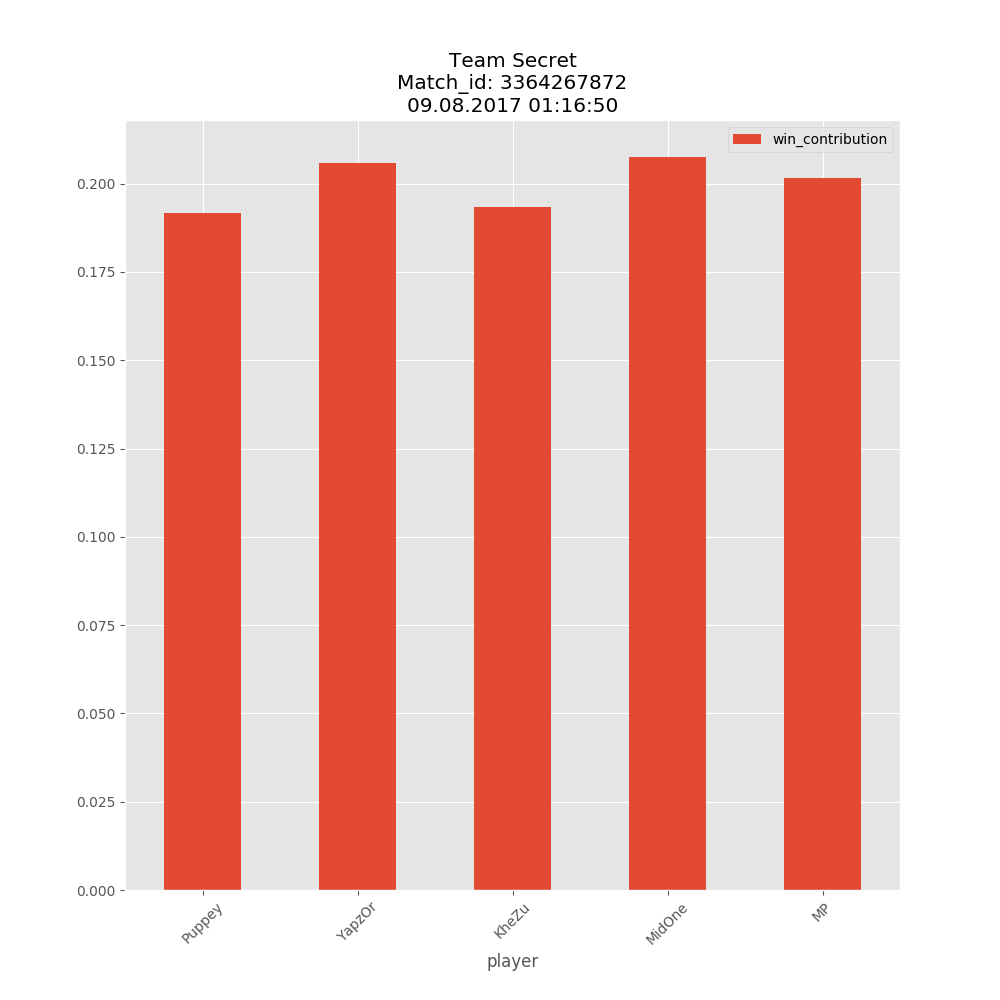

<IPython.core.display.Javascript object>


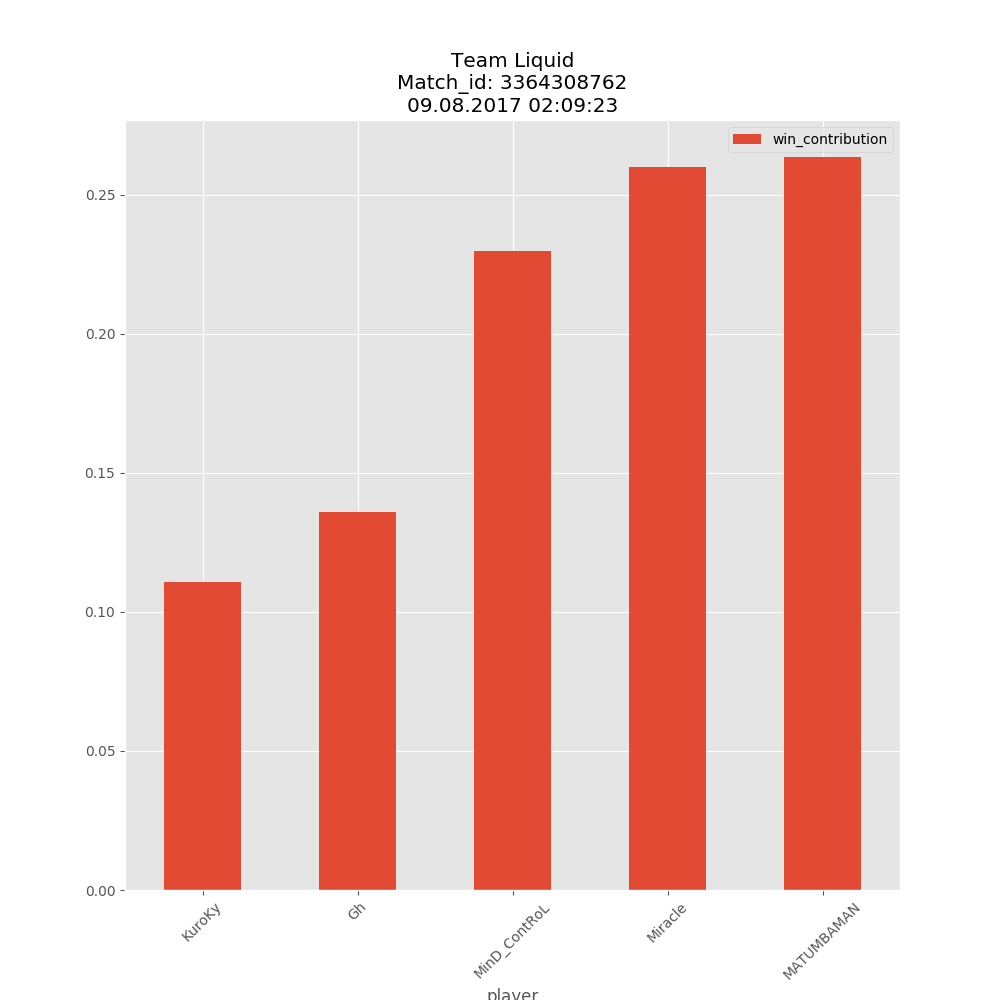

<IPython.core.display.Javascript object>


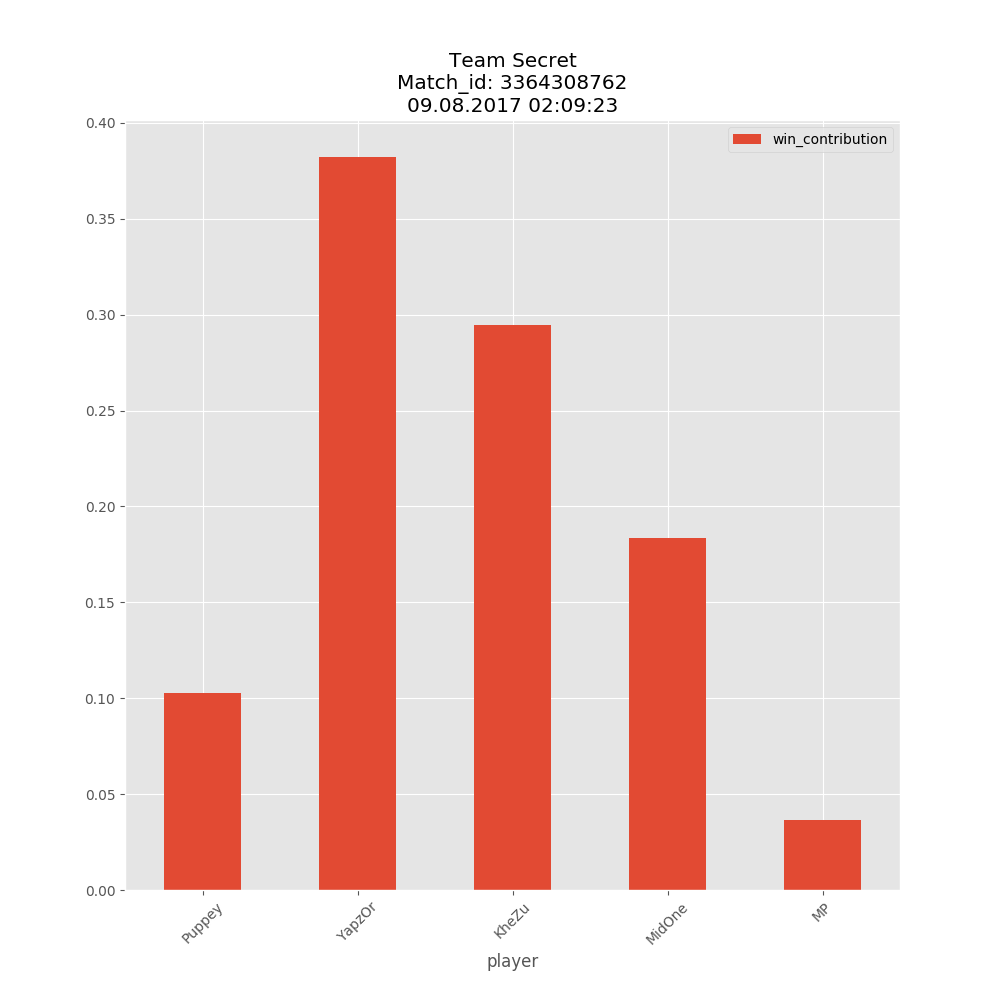

<IPython.core.display.Javascript object>


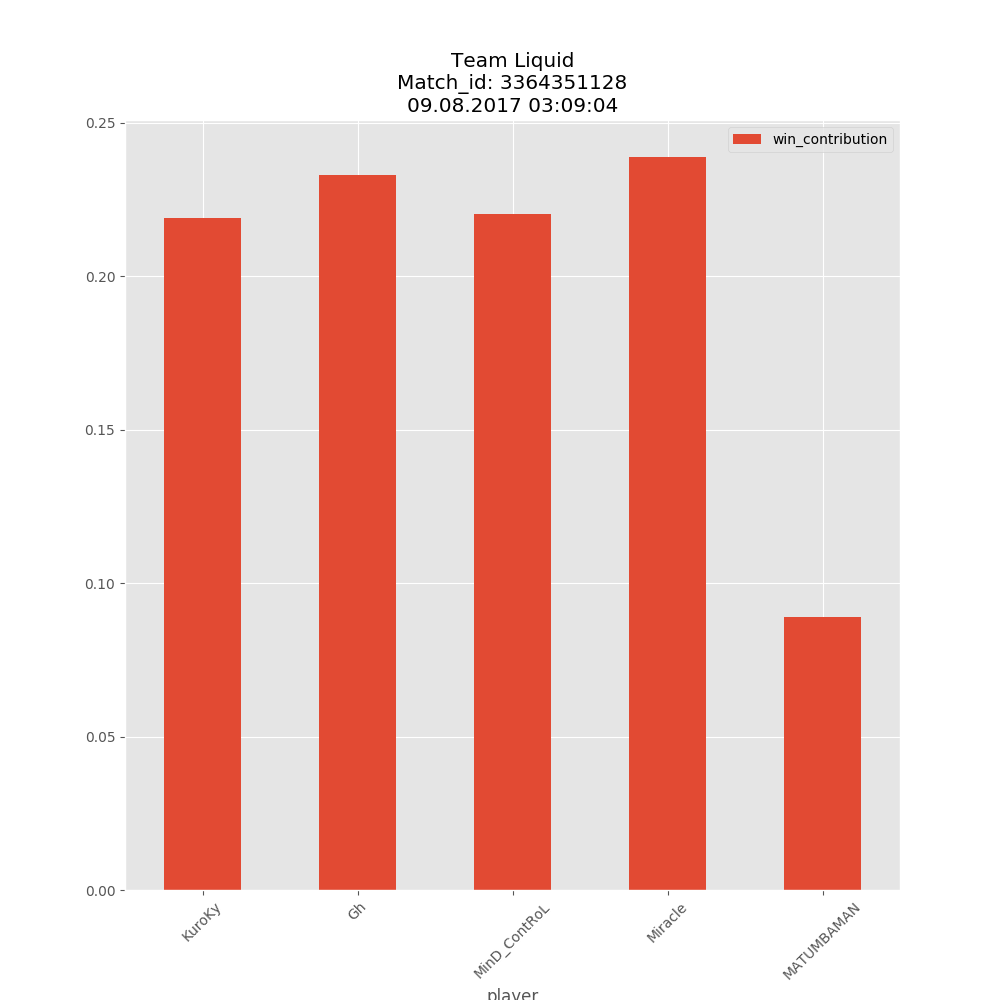

<IPython.core.display.Javascript object>


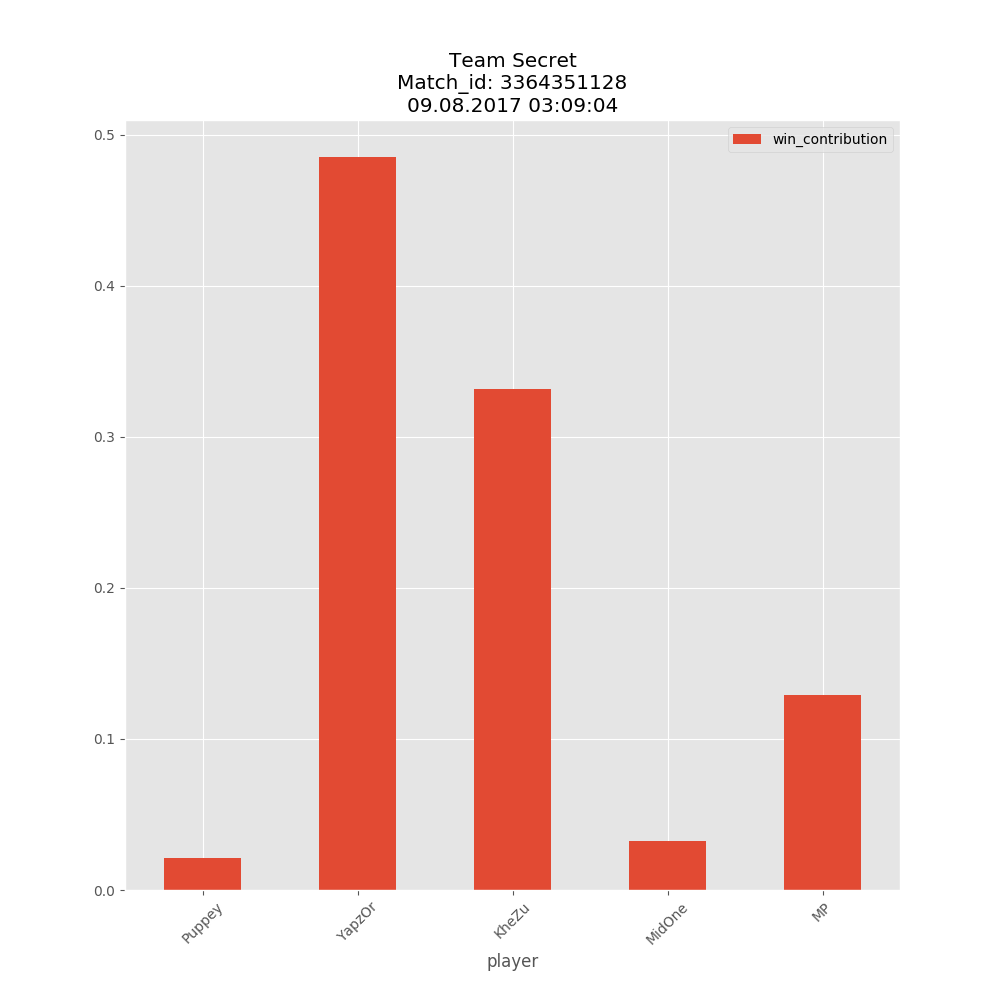

<IPython.core.display.Javascript object>


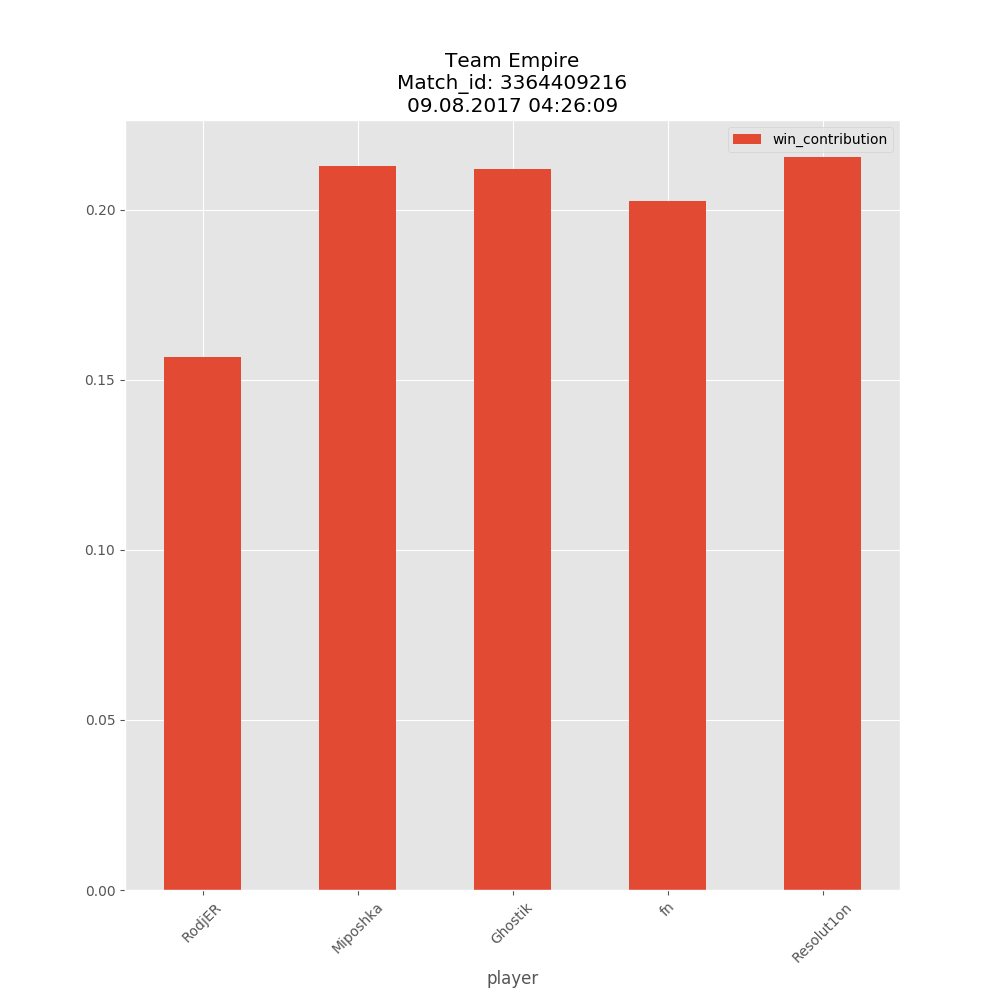

<IPython.core.display.Javascript object>


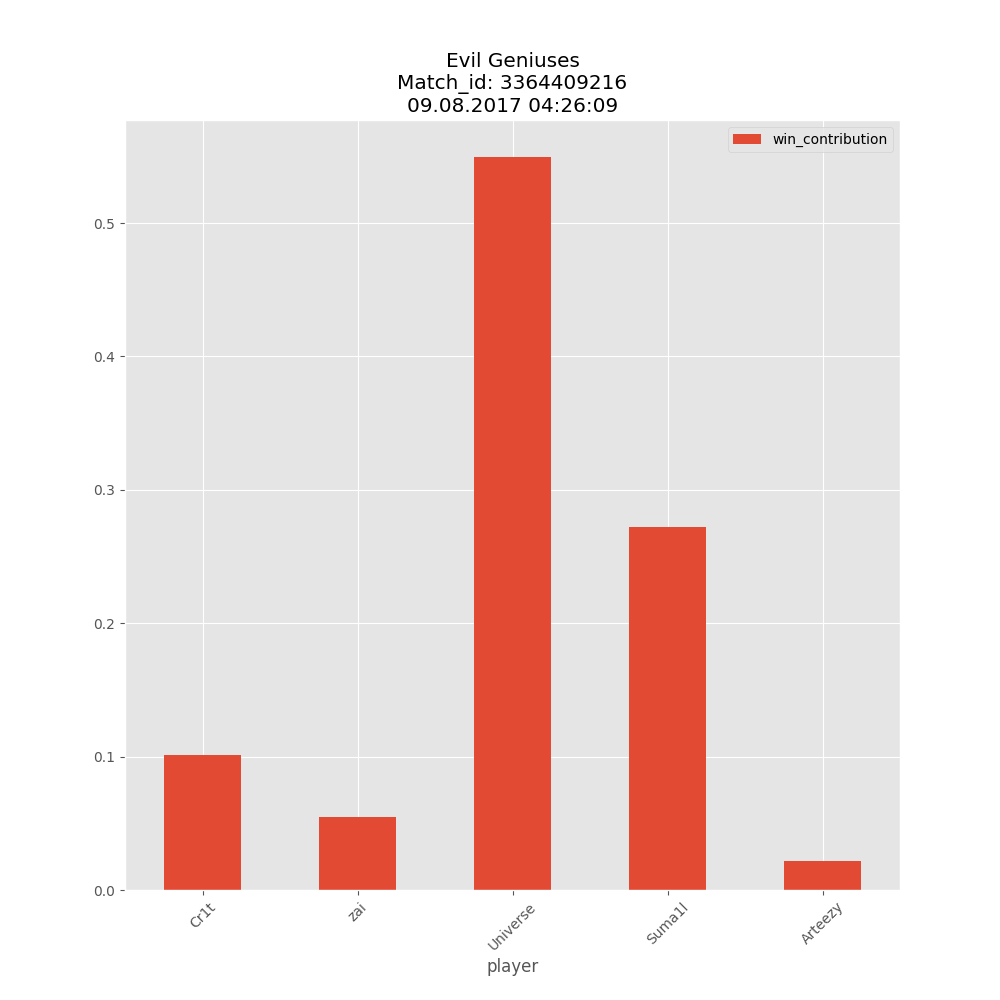

<IPython.core.display.Javascript object>


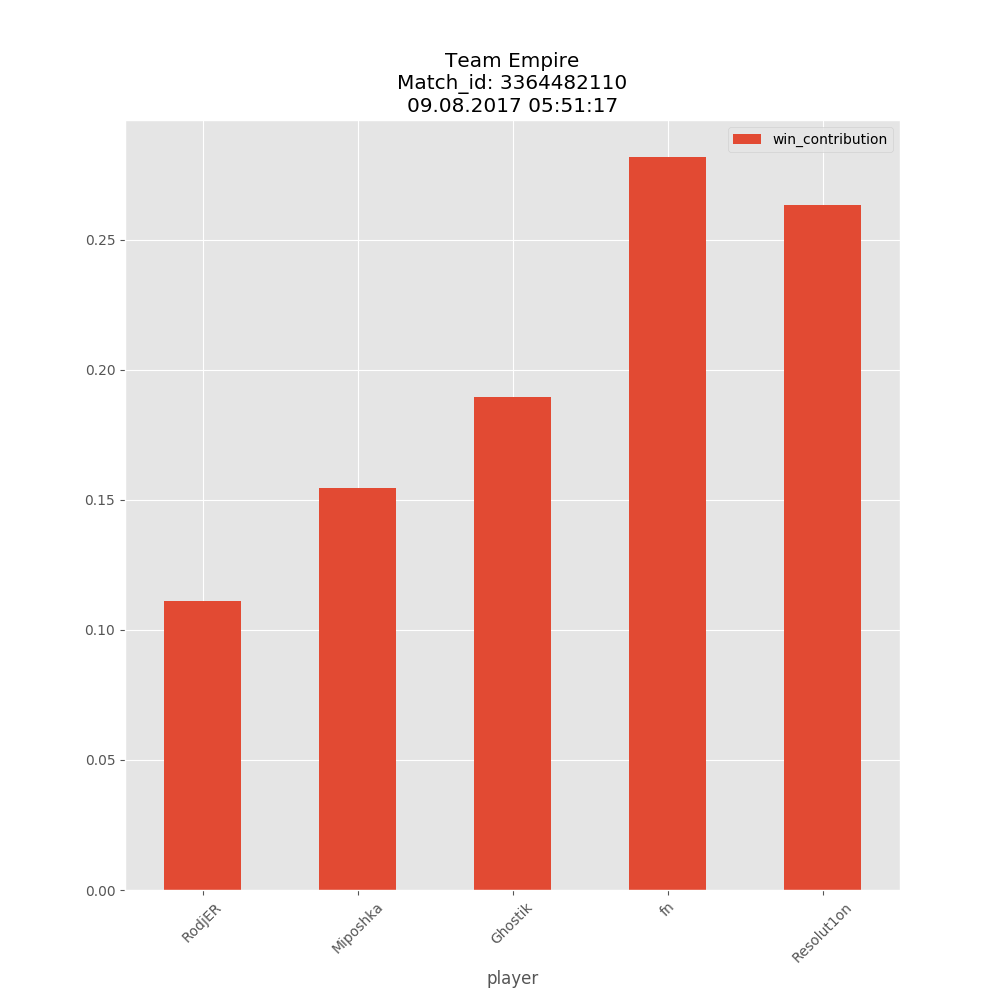

<IPython.core.display.Javascript object>


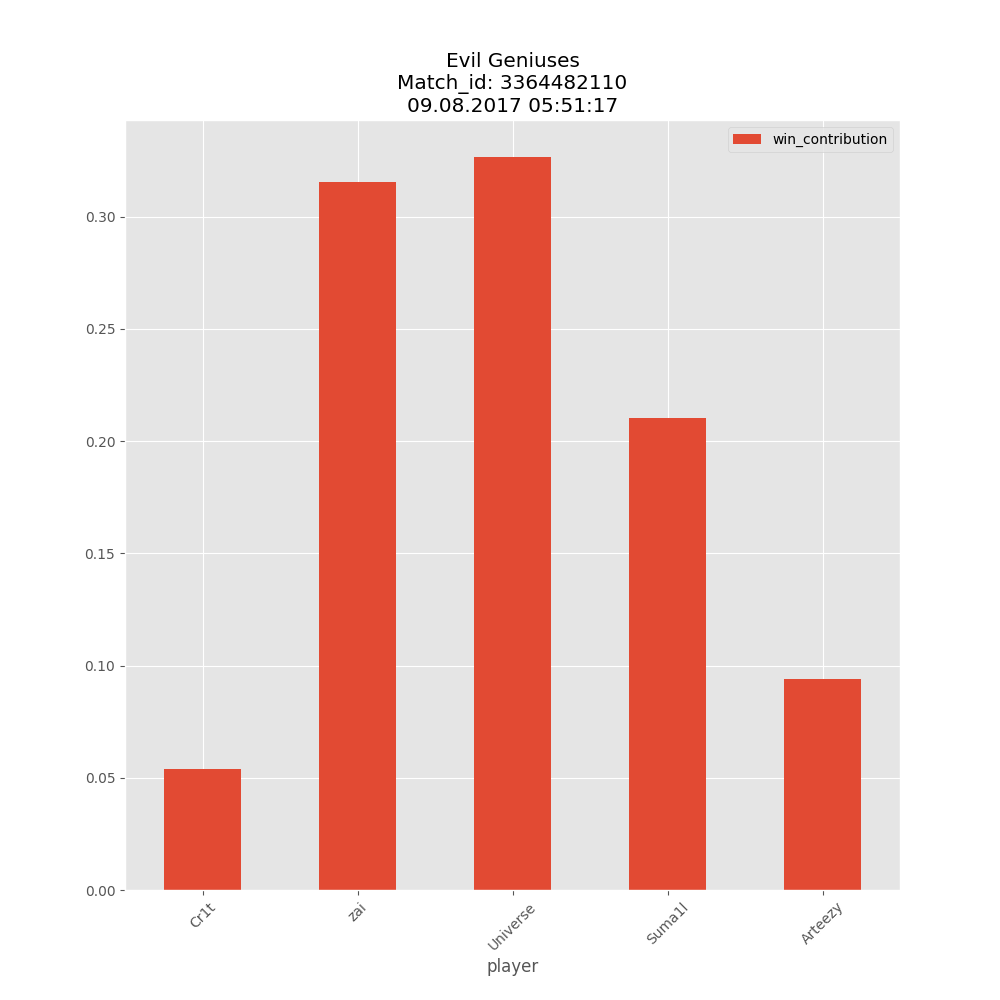

<IPython.core.display.Javascript object>


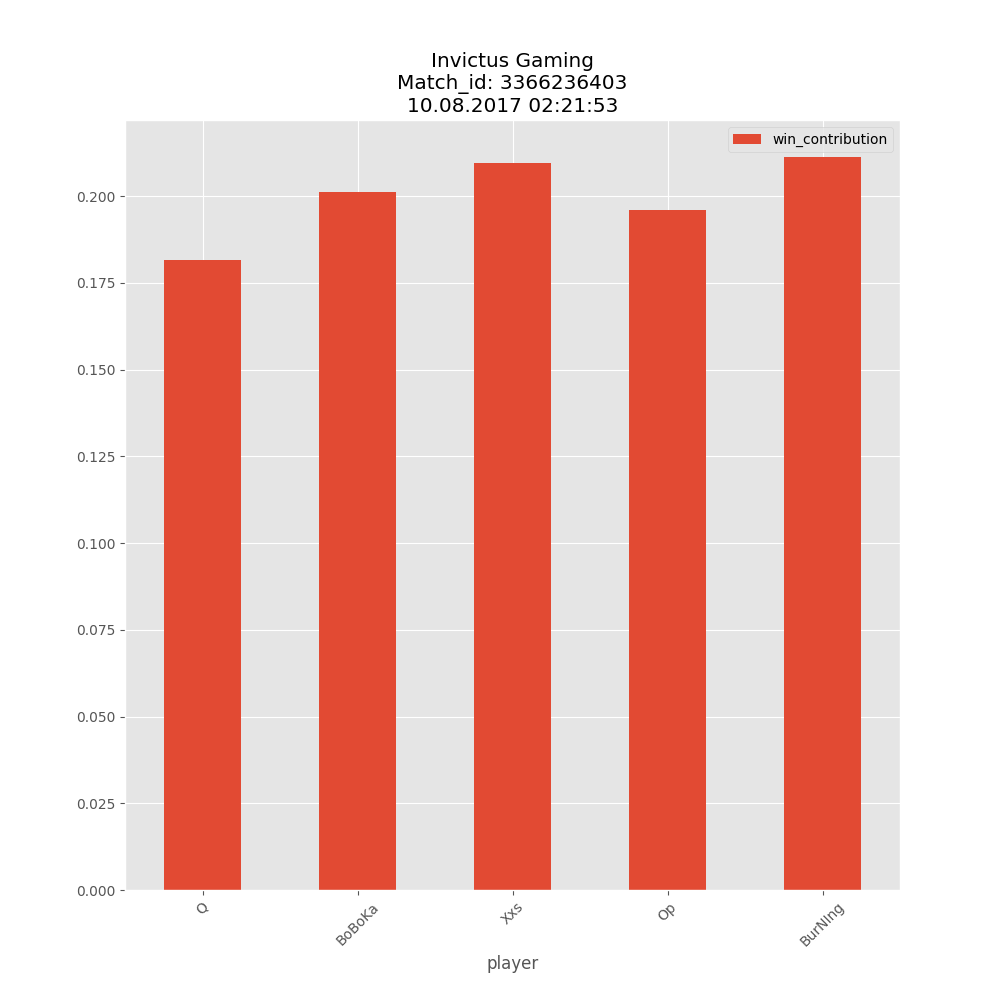

<IPython.core.display.Javascript object>


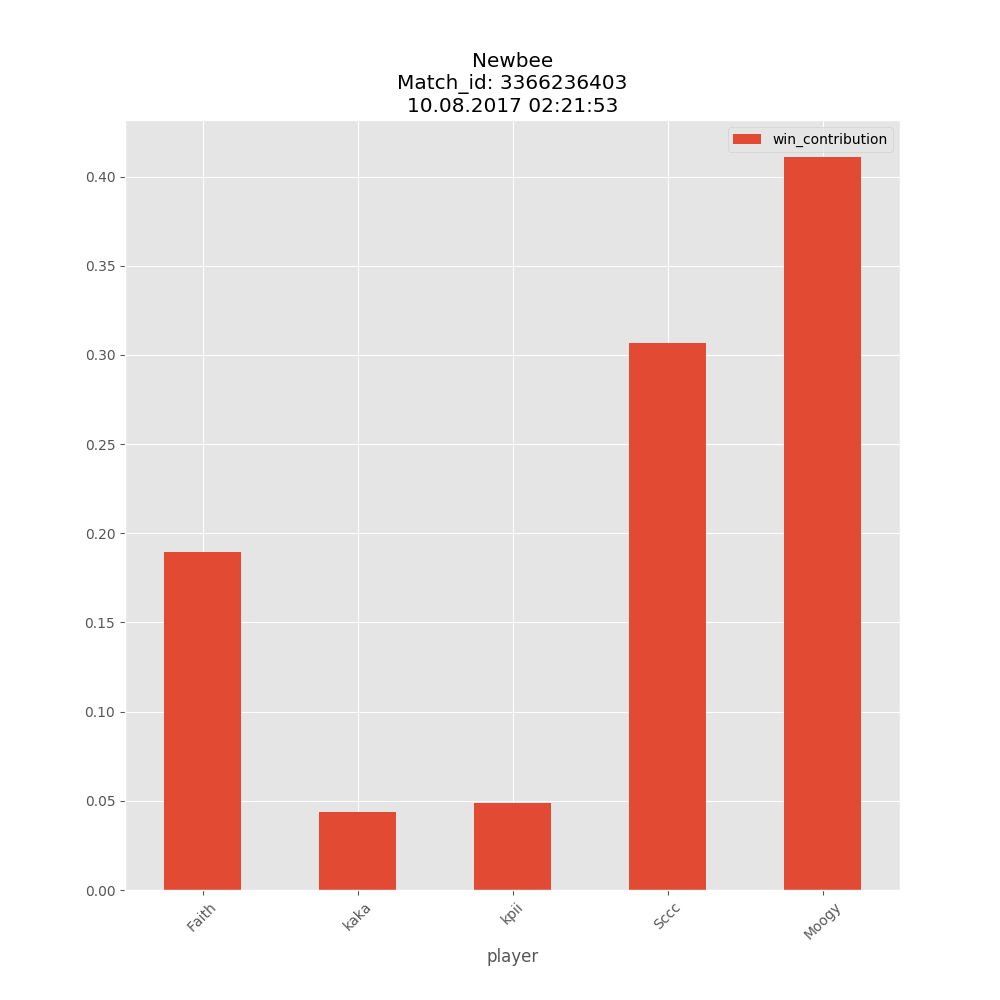

<IPython.core.display.Javascript object>


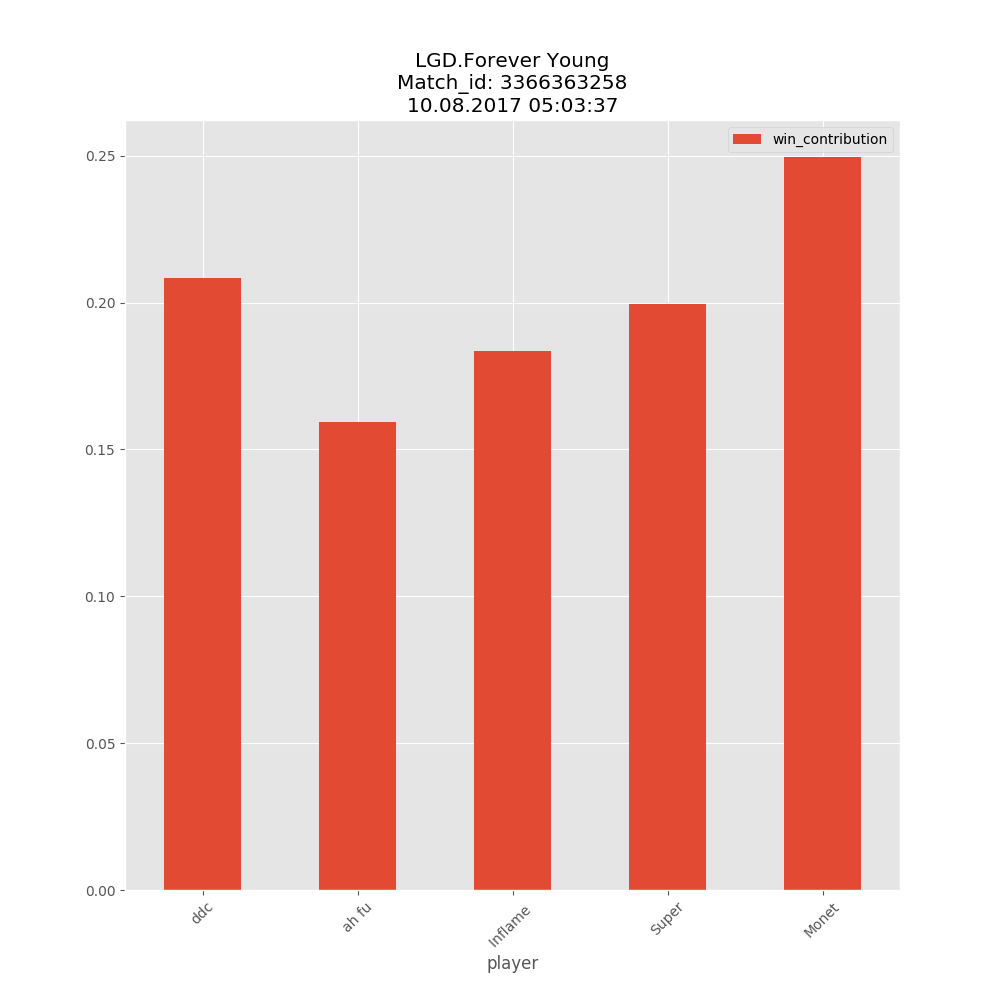

<IPython.core.display.Javascript object>


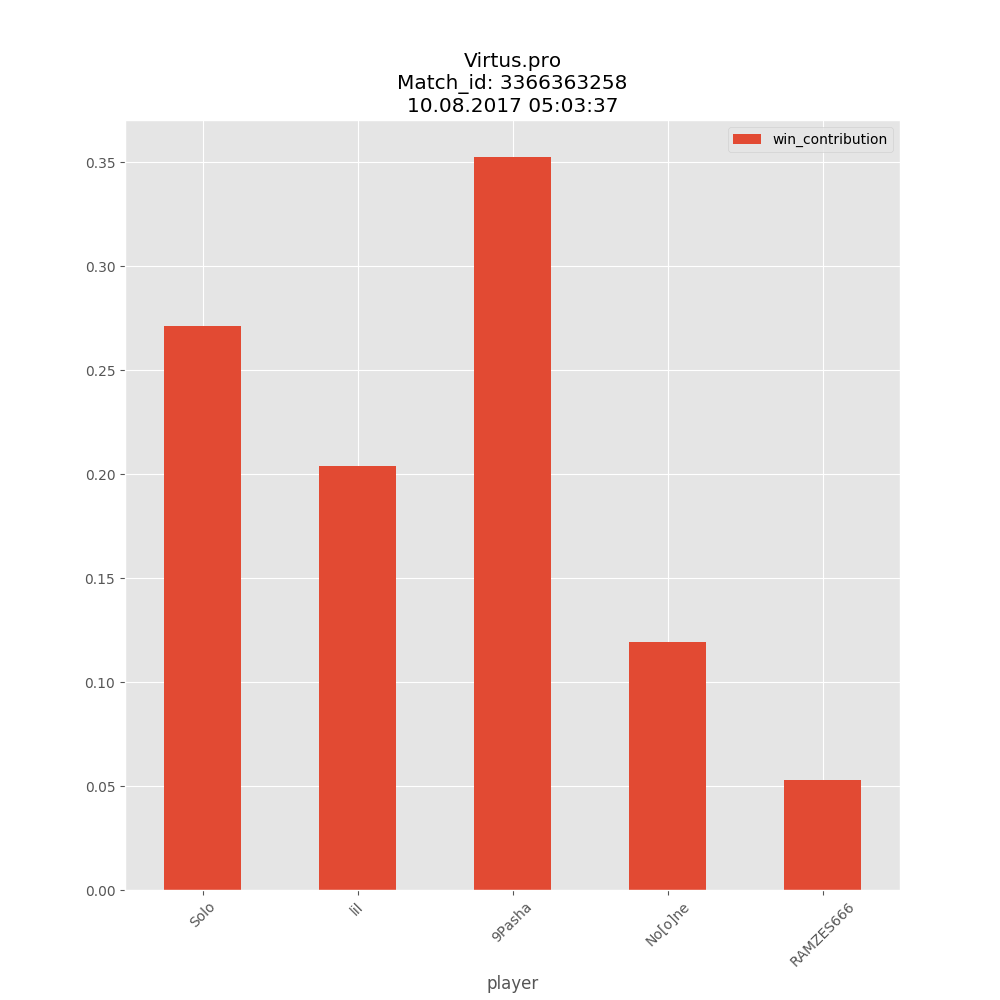

<IPython.core.display.Javascript object>


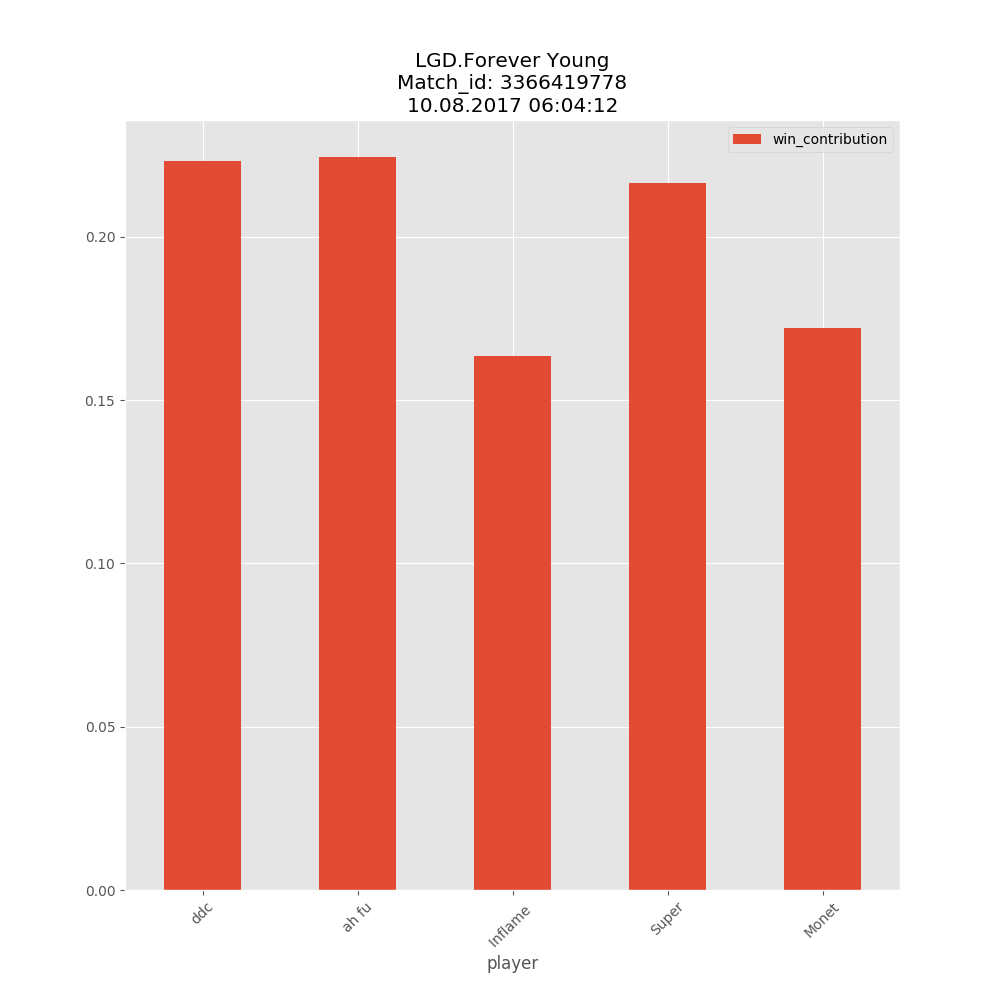

<IPython.core.display.Javascript object>


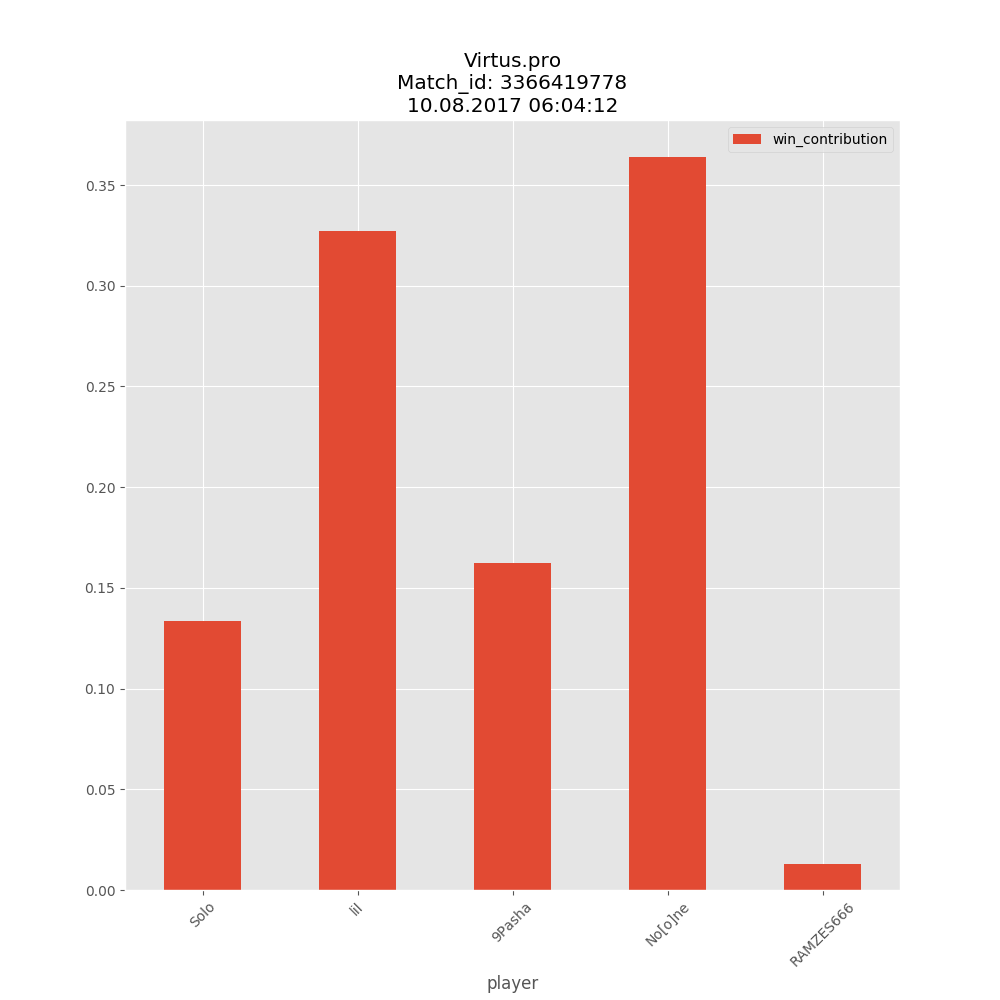

<IPython.core.display.Javascript object>


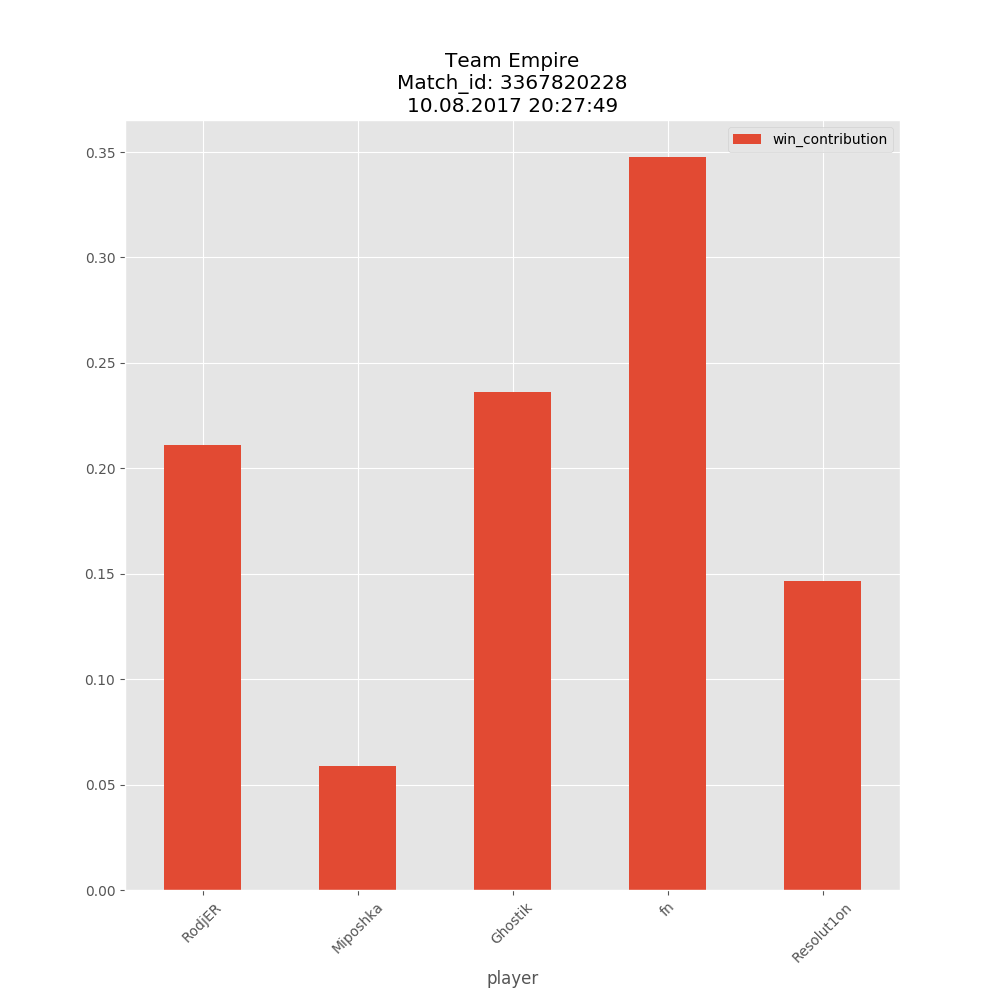

<IPython.core.display.Javascript object>


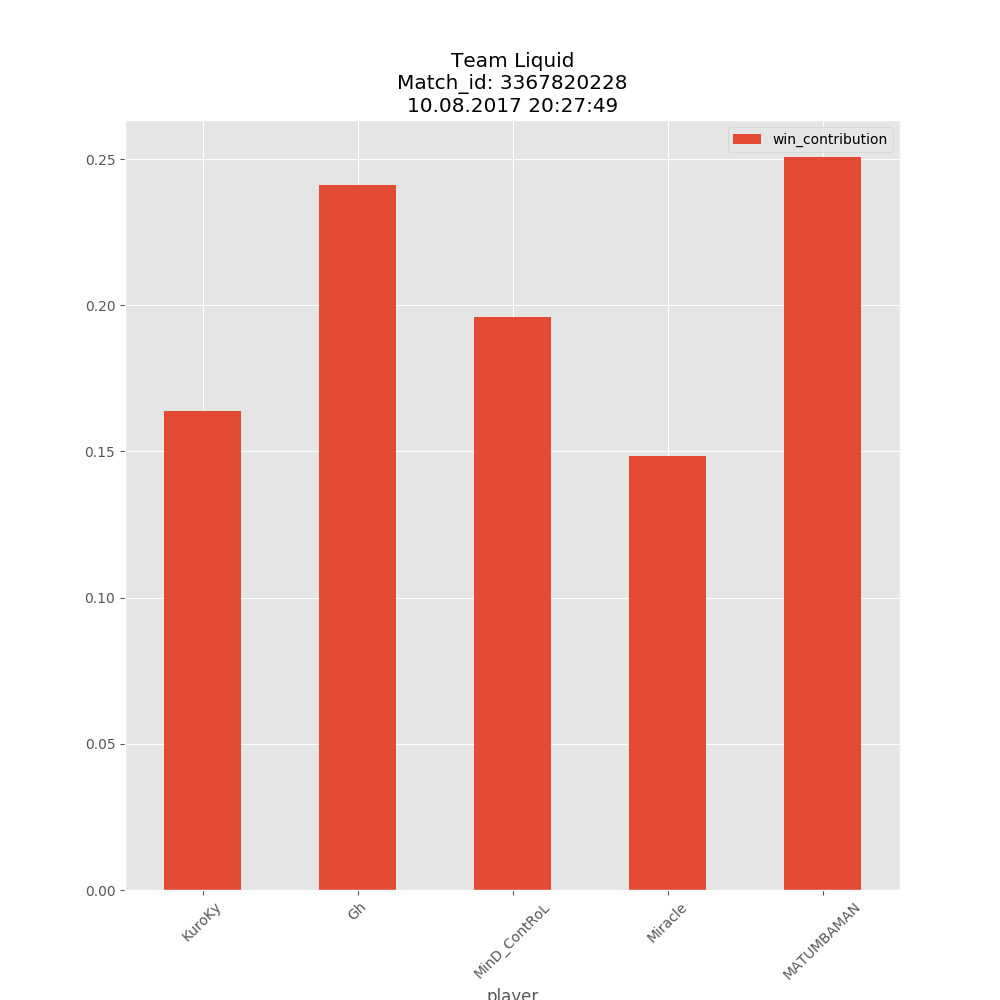

<IPython.core.display.Javascript object>


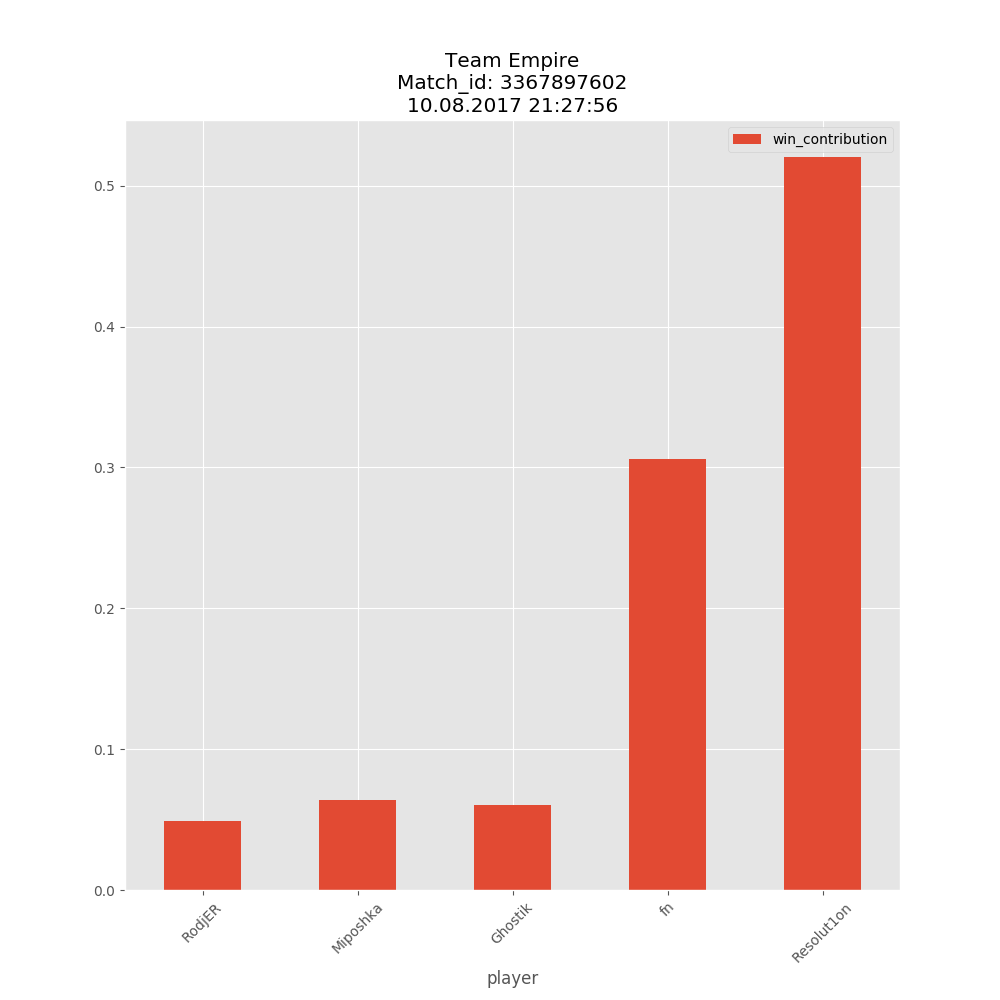

<IPython.core.display.Javascript object>


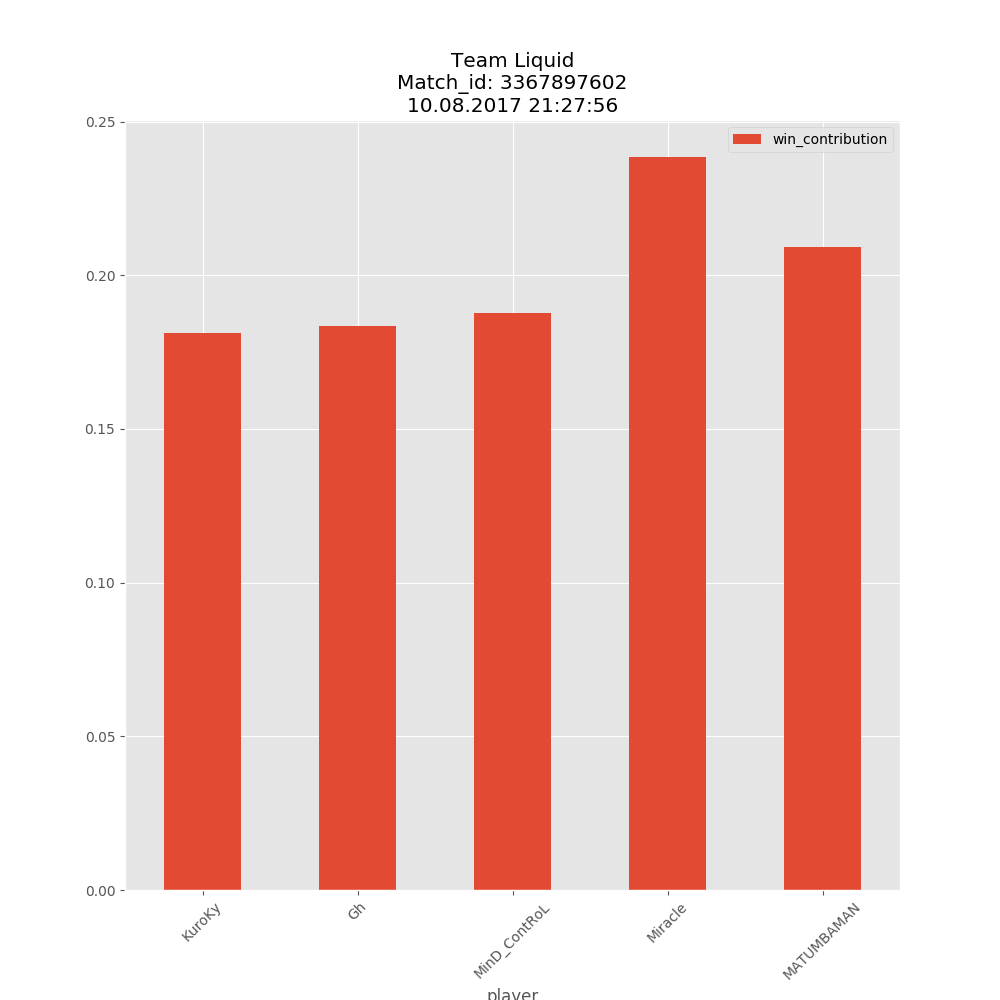

<IPython.core.display.Javascript object>


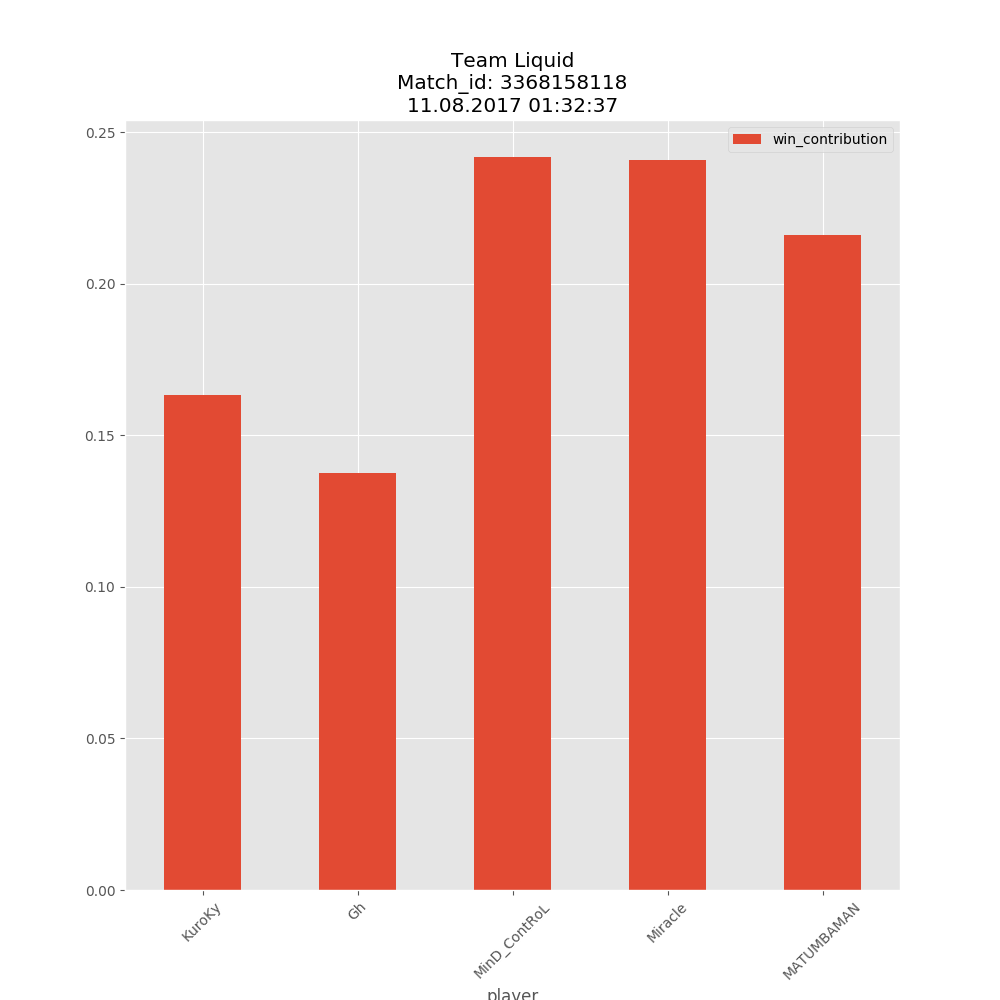

<IPython.core.display.Javascript object>


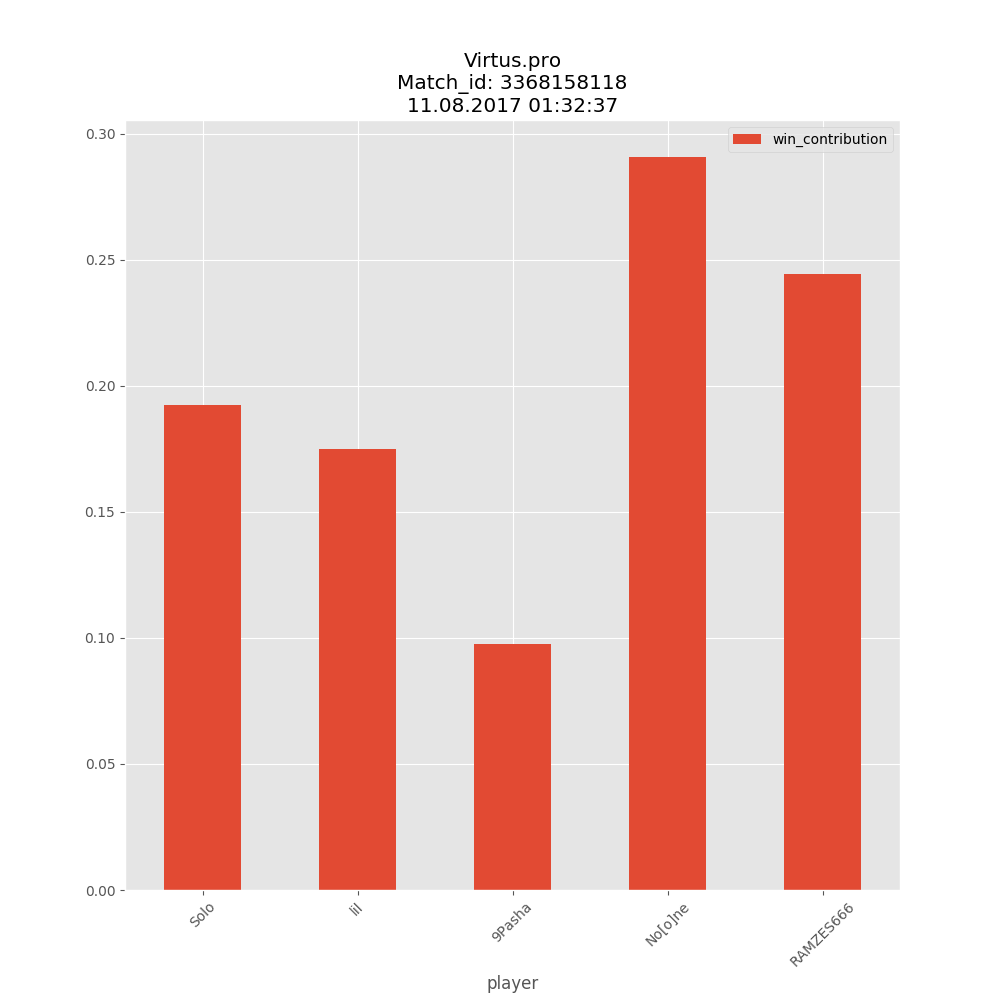

<IPython.core.display.Javascript object>


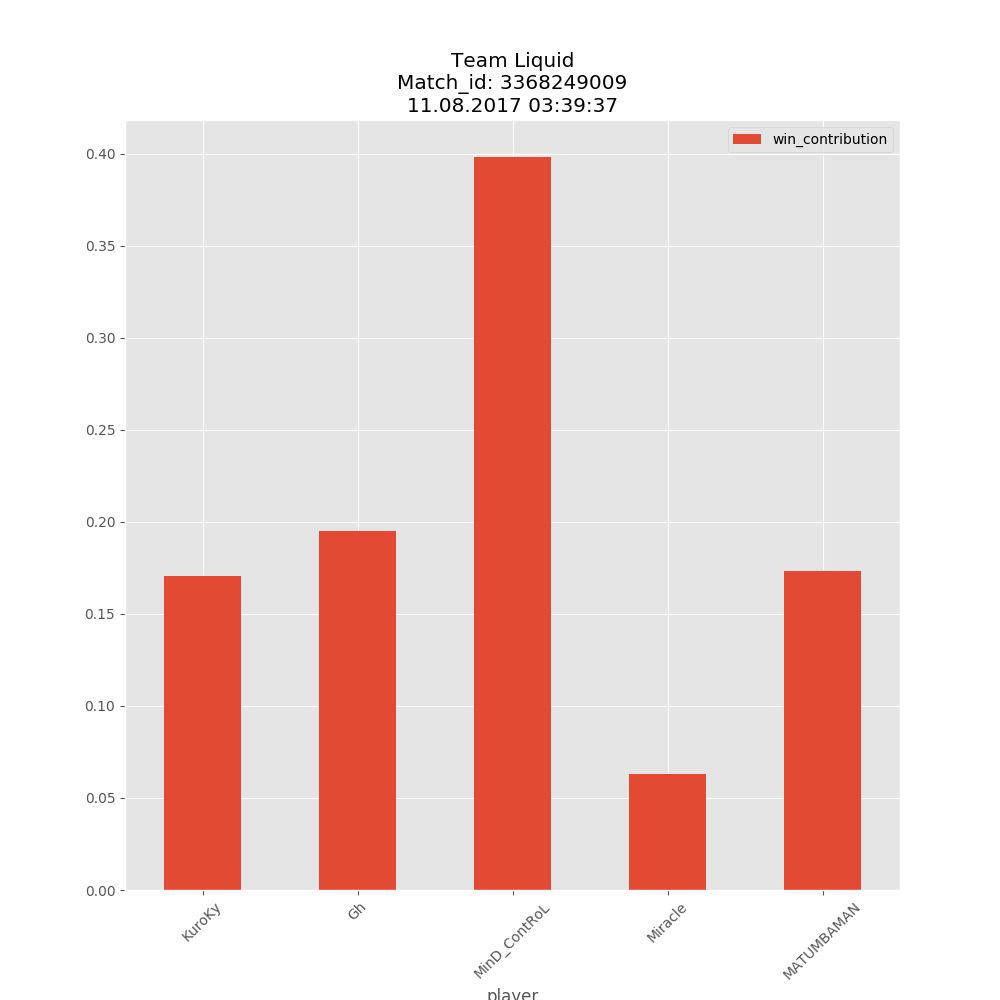

<IPython.core.display.Javascript object>


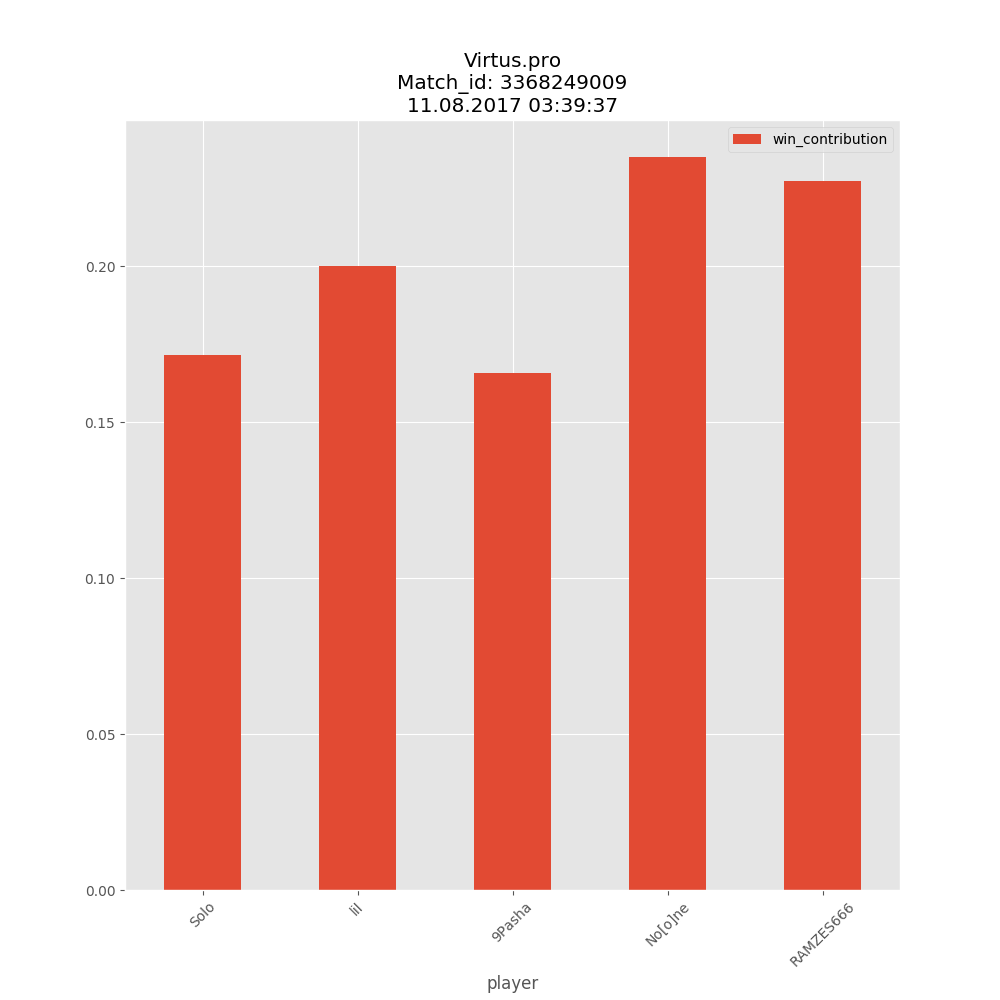

<IPython.core.display.Javascript object>


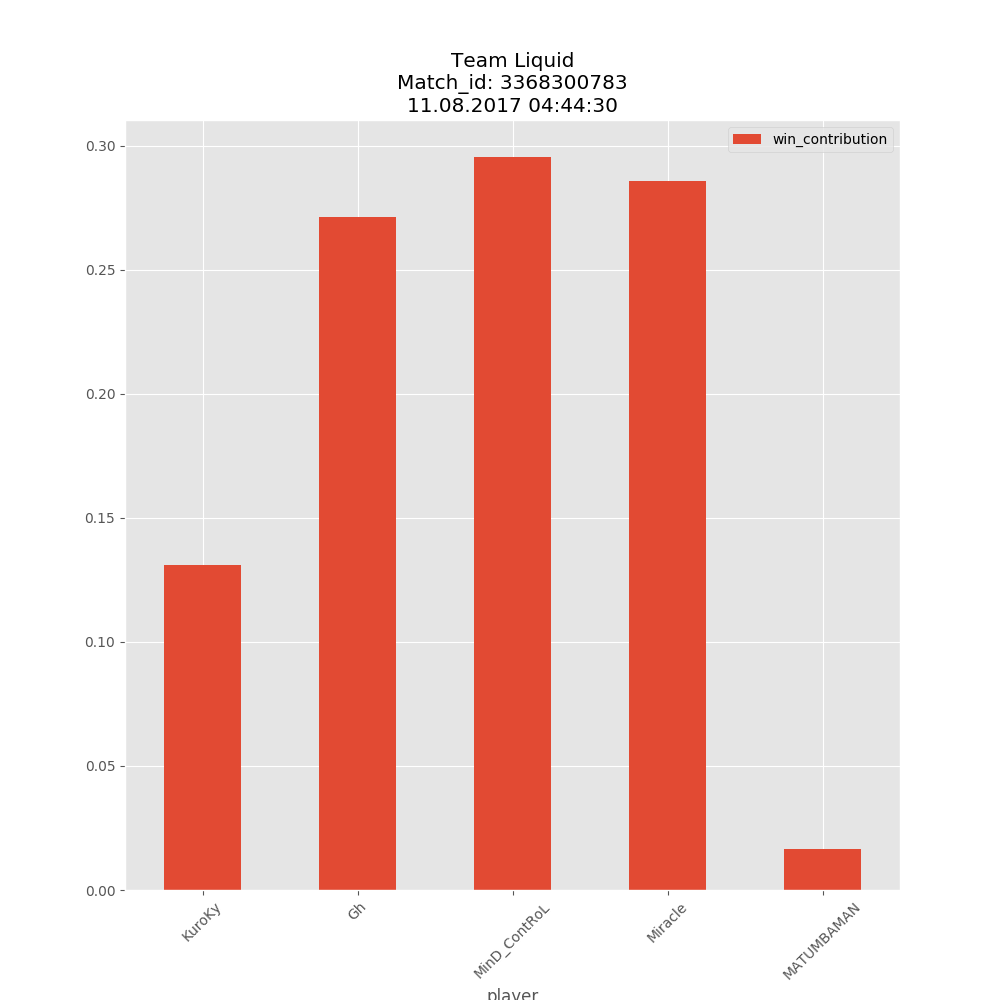

<IPython.core.display.Javascript object>


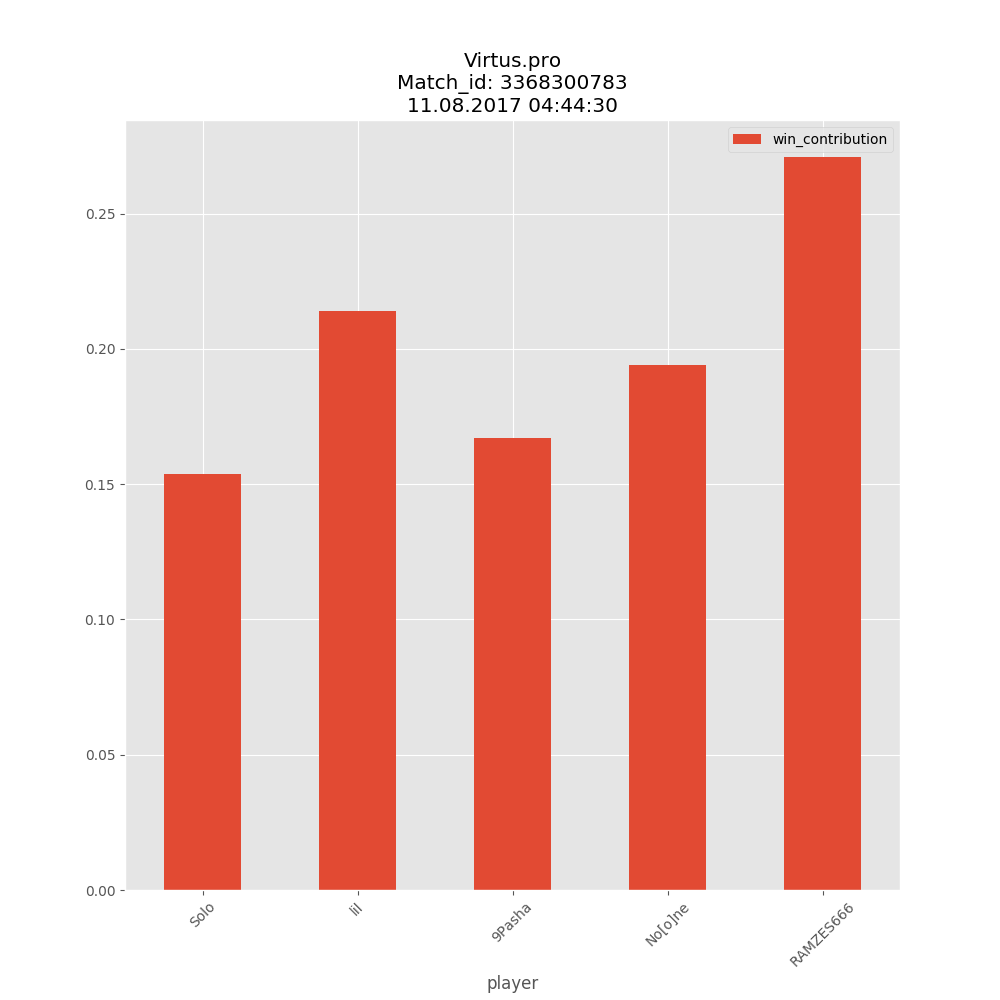

<IPython.core.display.Javascript object>


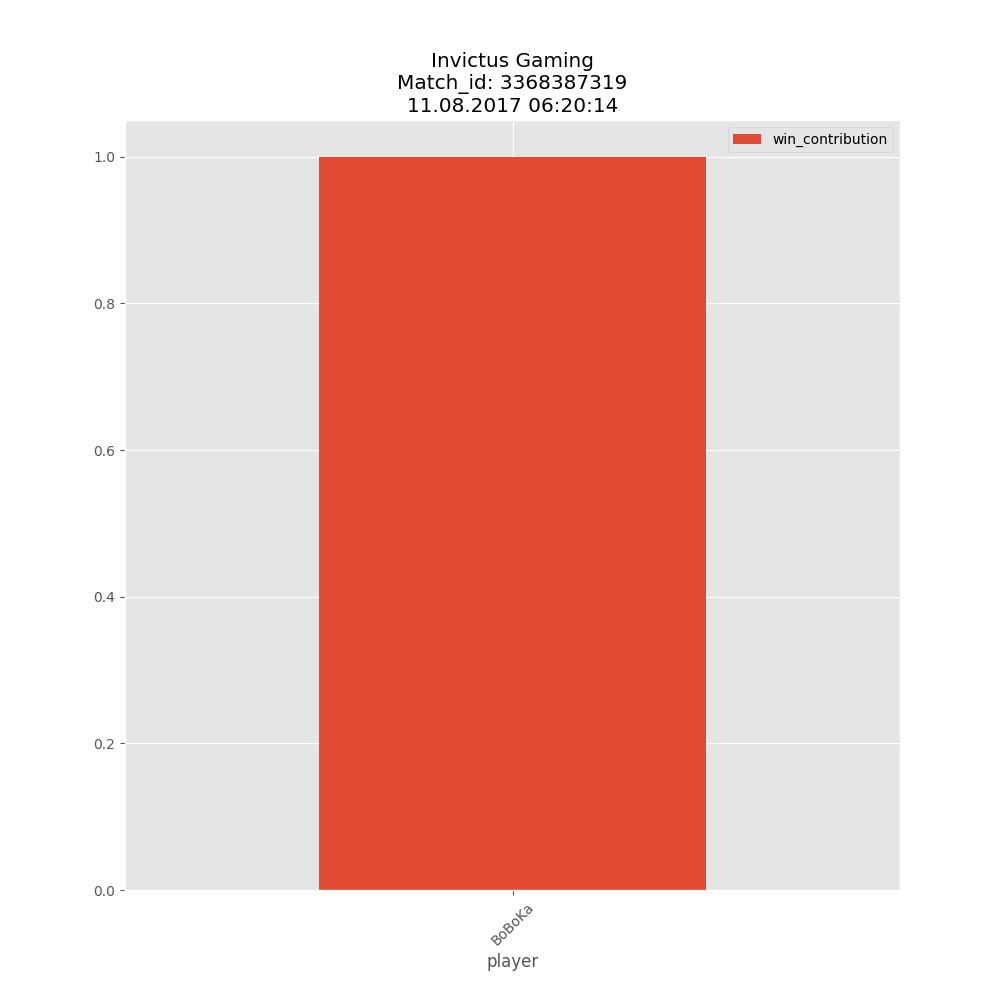

<IPython.core.display.Javascript object>


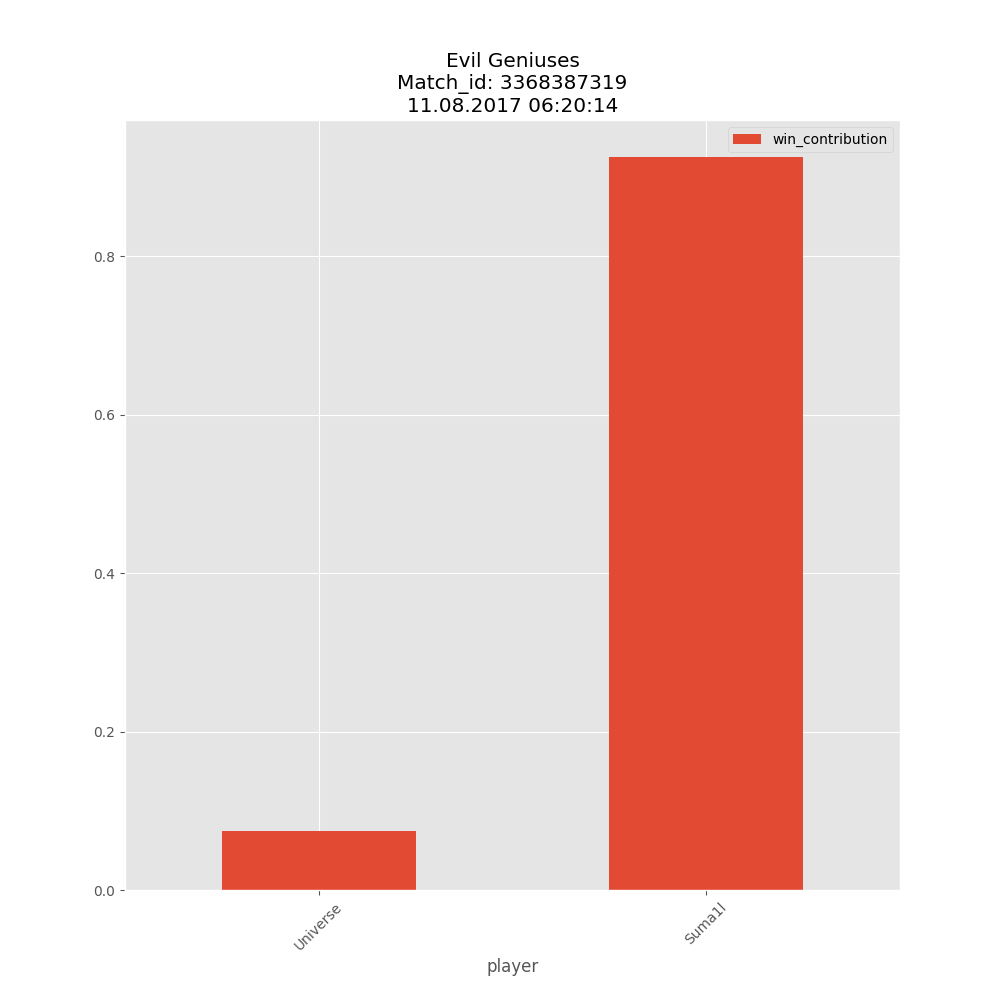

<IPython.core.display.Javascript object>


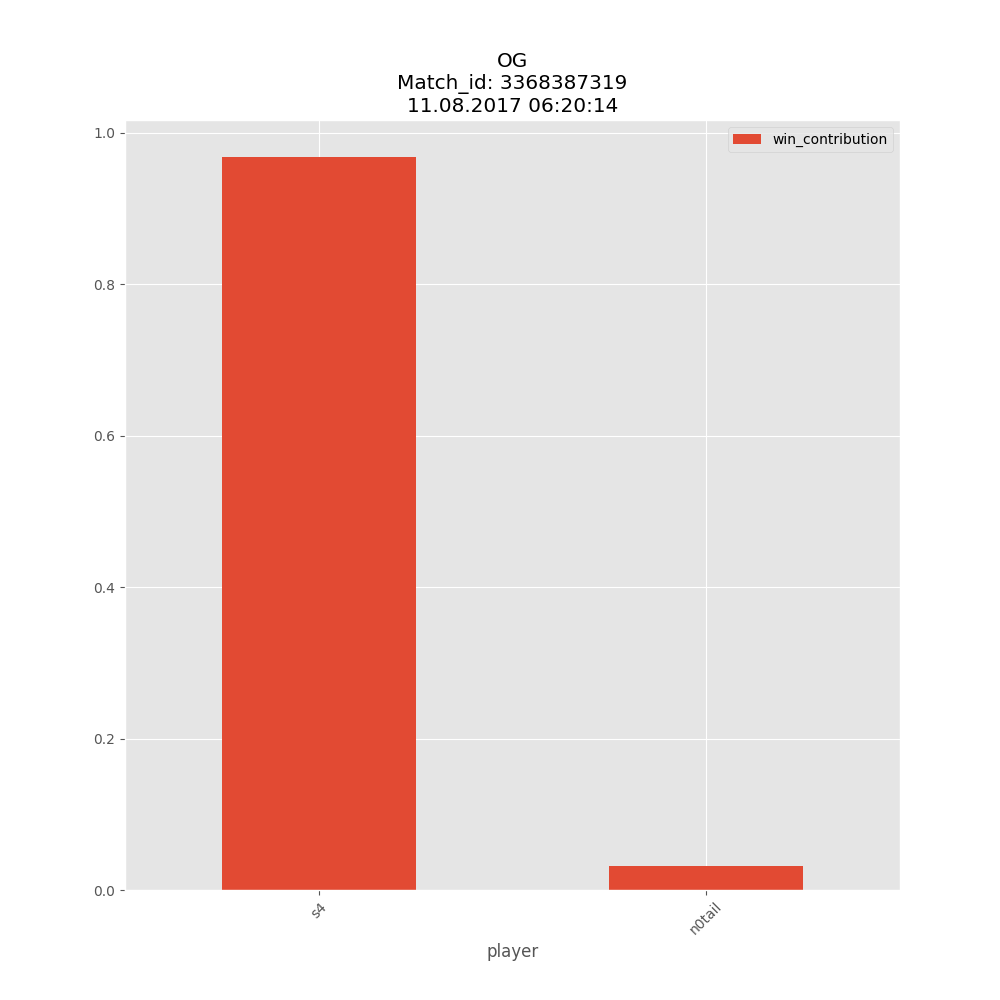

<IPython.core.display.Javascript object>


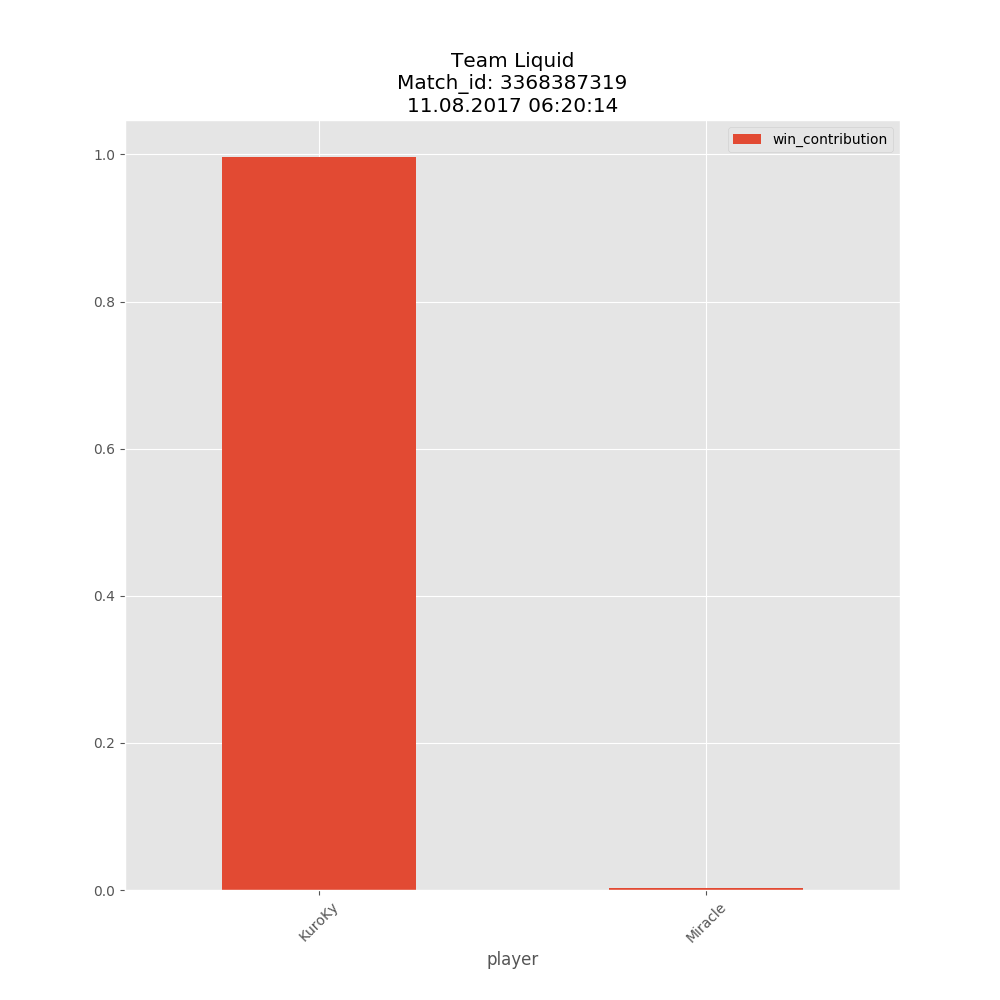

<IPython.core.display.Javascript object>


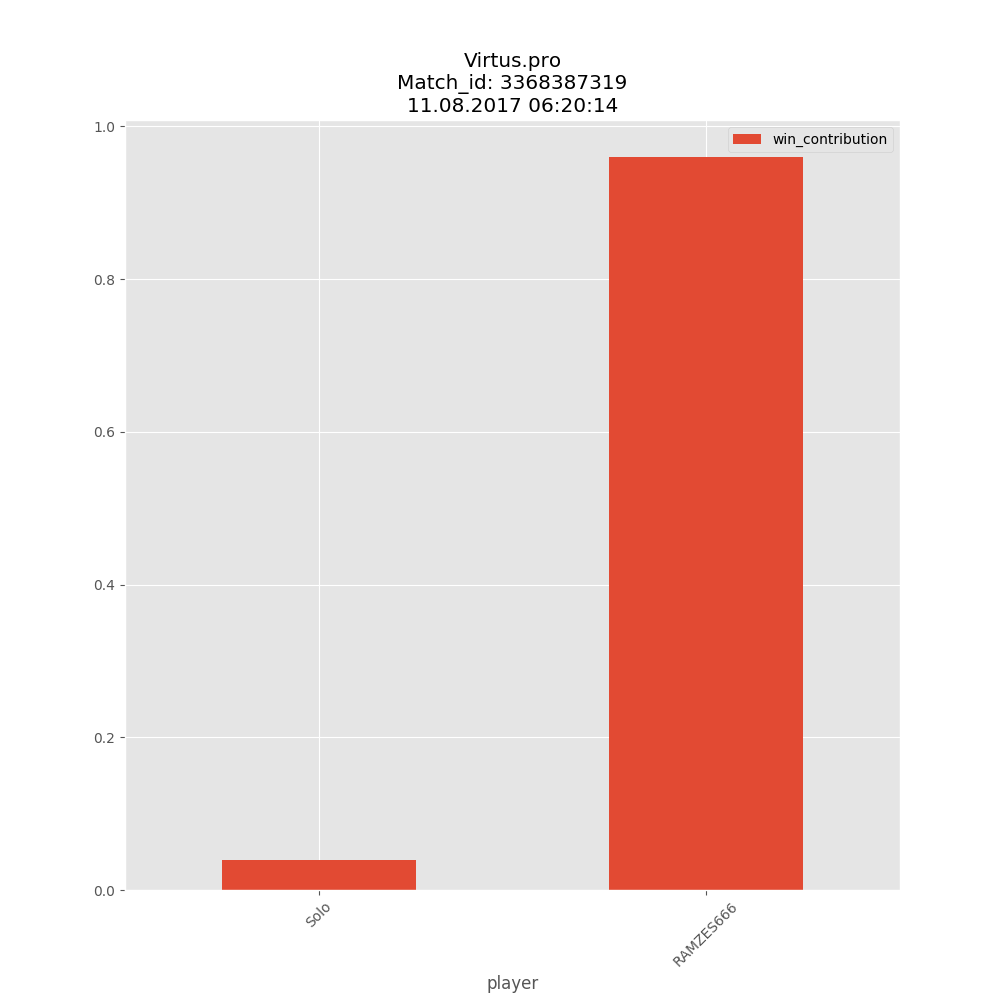

<IPython.core.display.Javascript object>


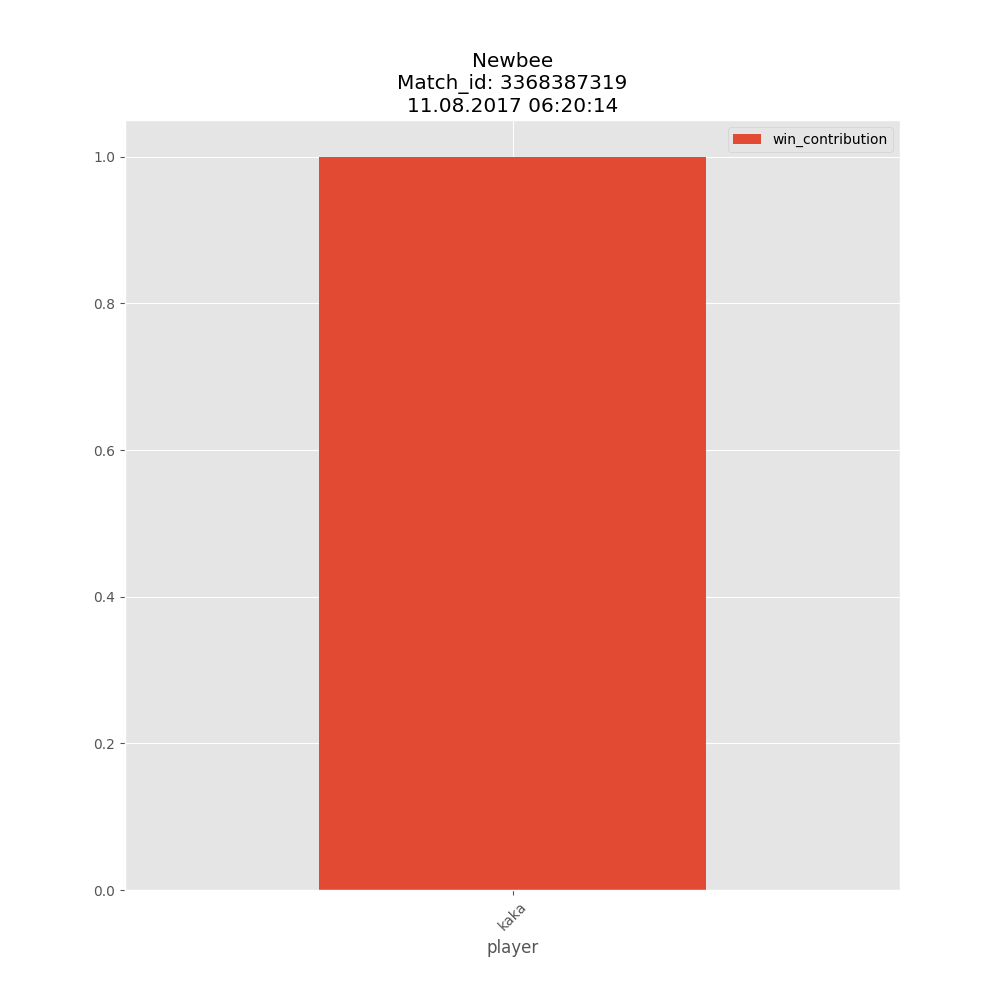

<IPython.core.display.Javascript object>


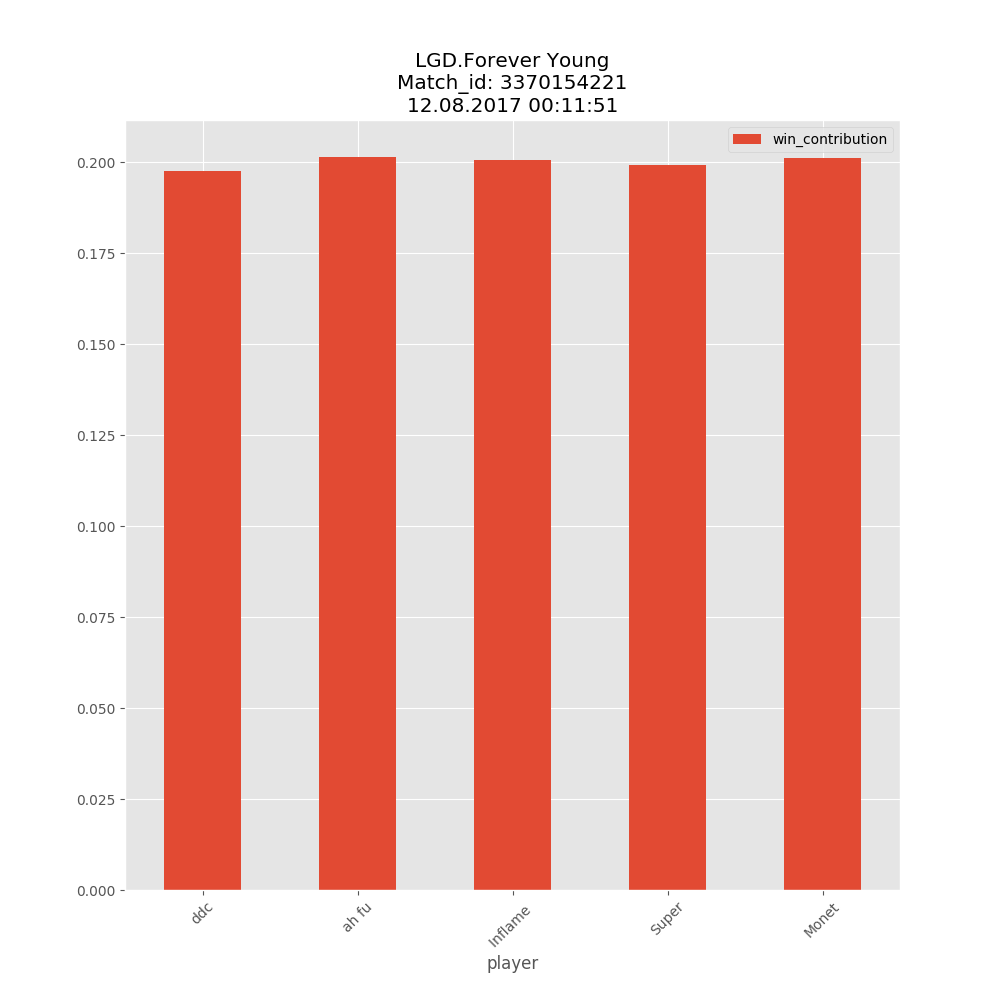

<IPython.core.display.Javascript object>


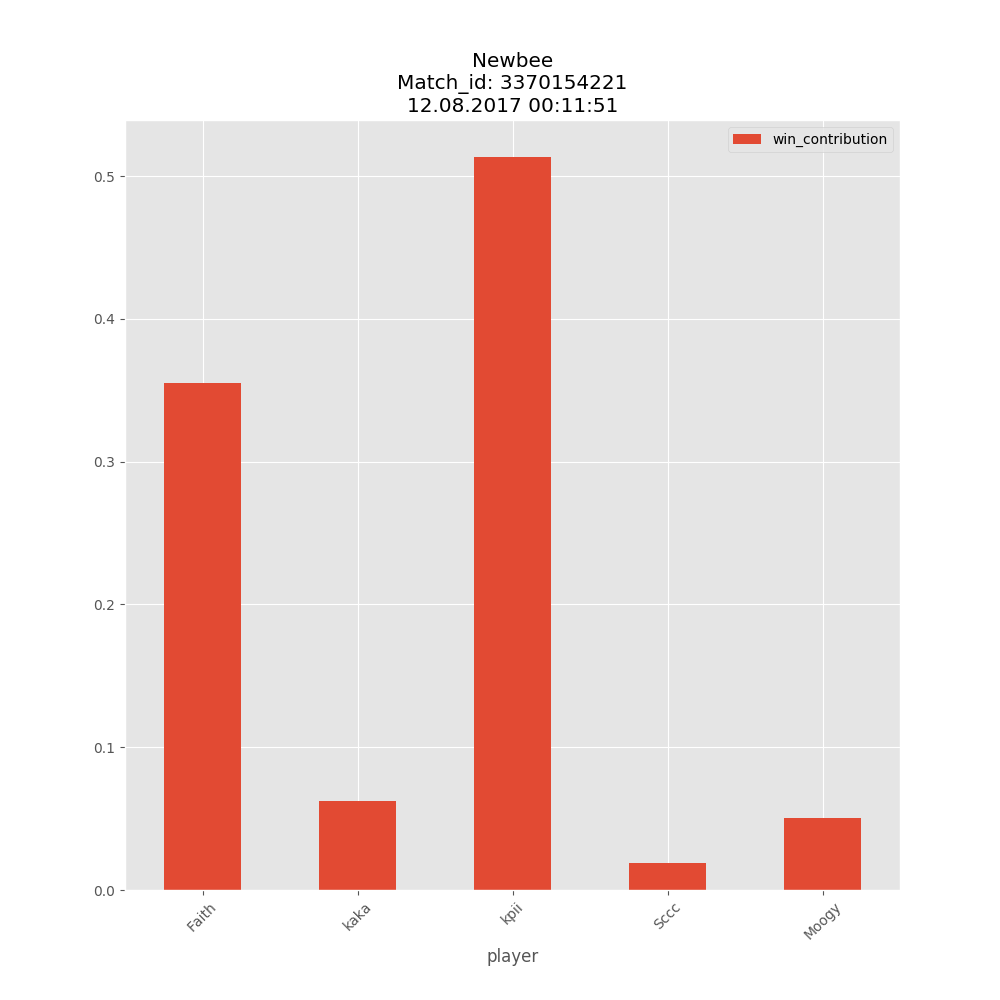

<IPython.core.display.Javascript object>


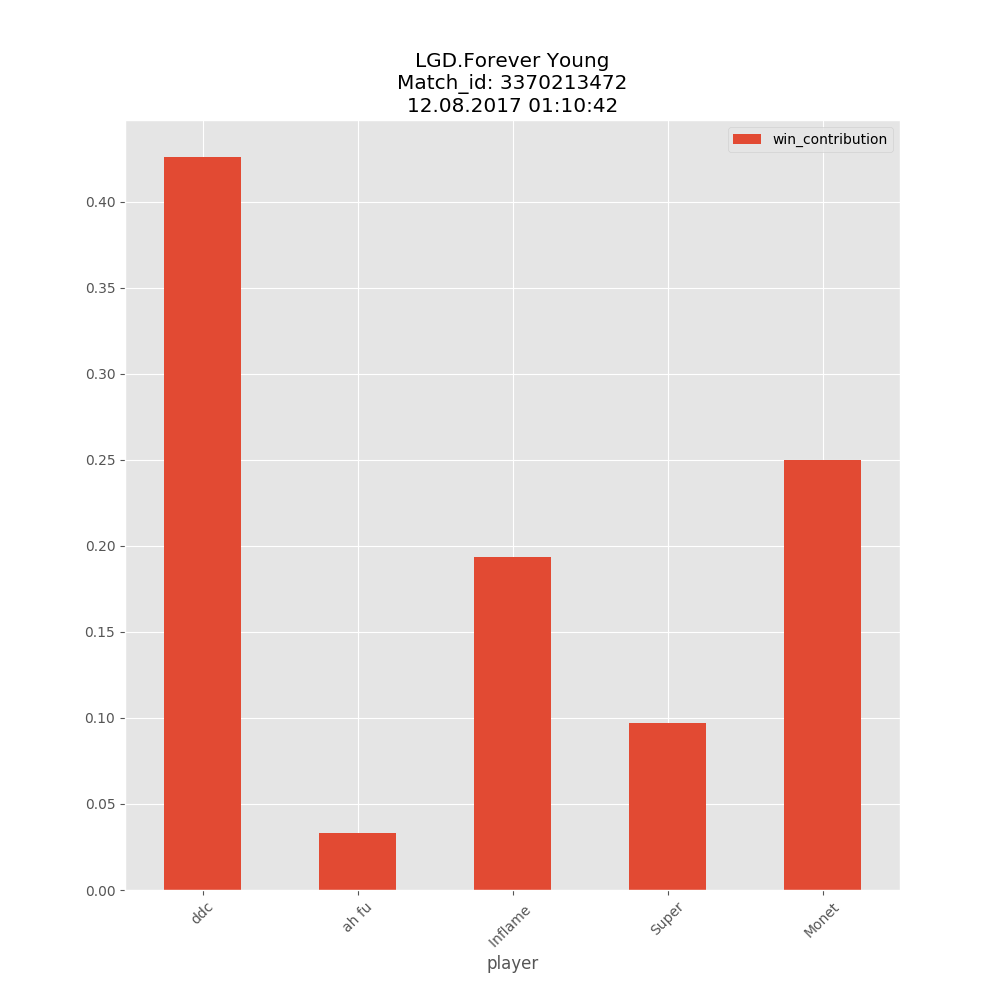

<IPython.core.display.Javascript object>


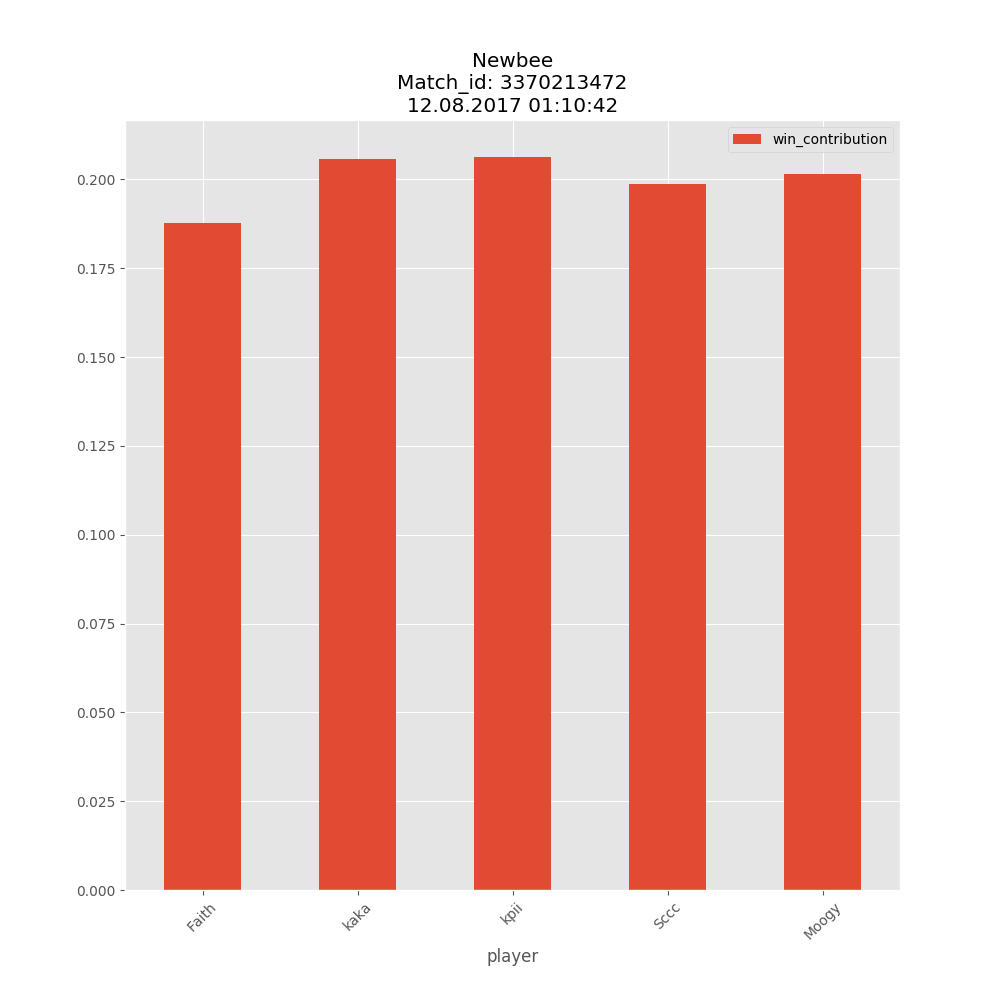

<IPython.core.display.Javascript object>


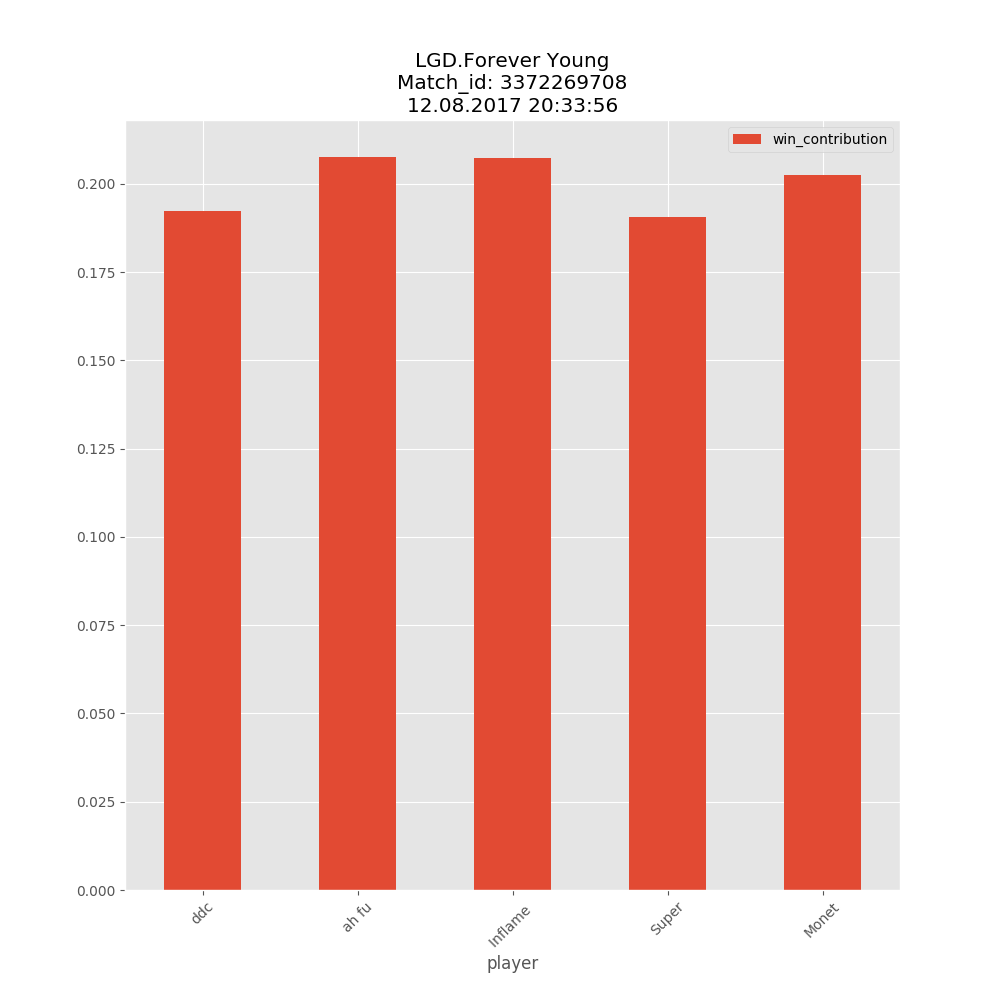

<IPython.core.display.Javascript object>


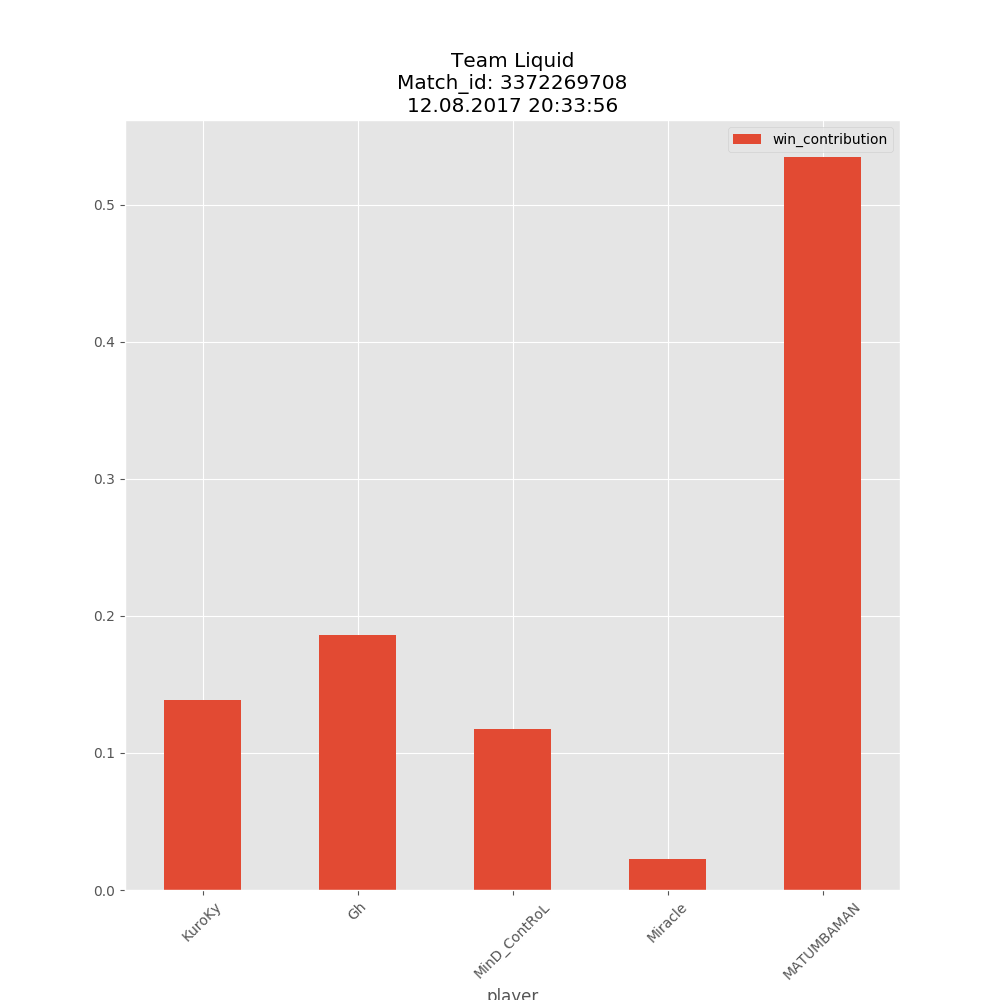

<IPython.core.display.Javascript object>


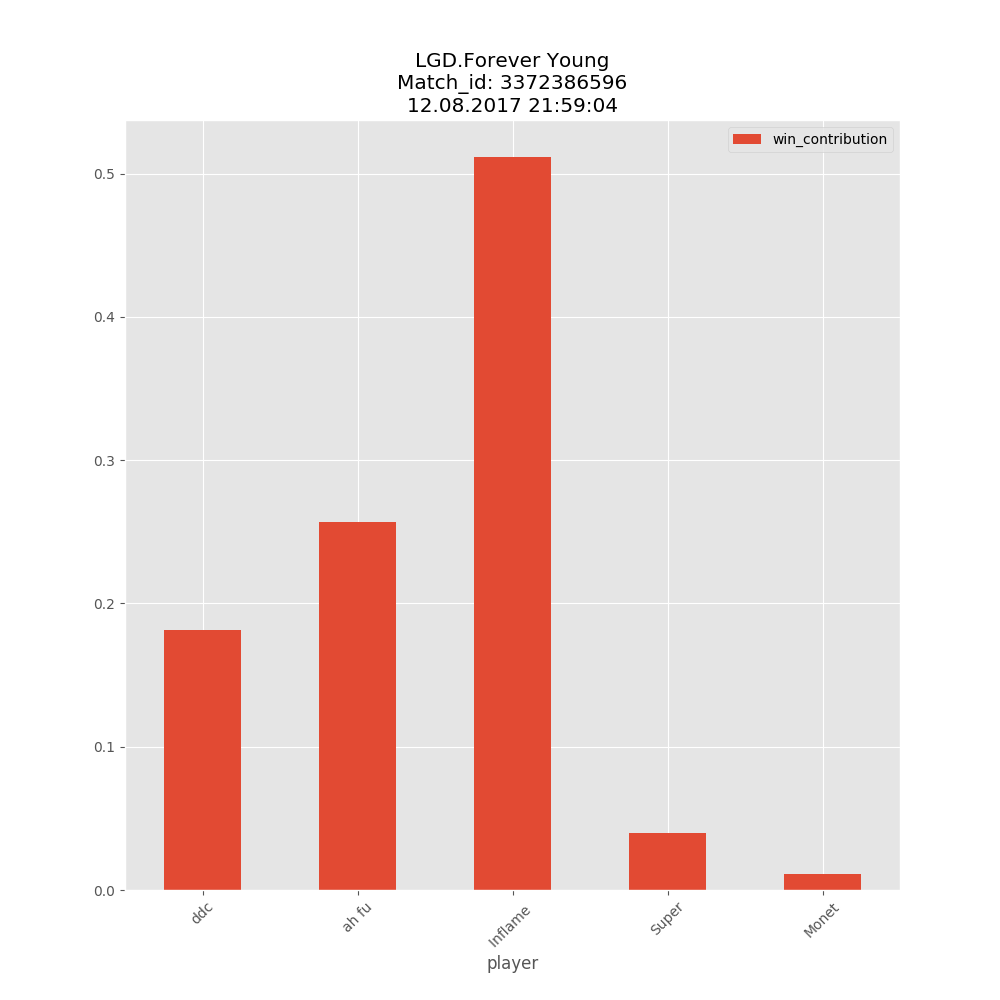

<IPython.core.display.Javascript object>


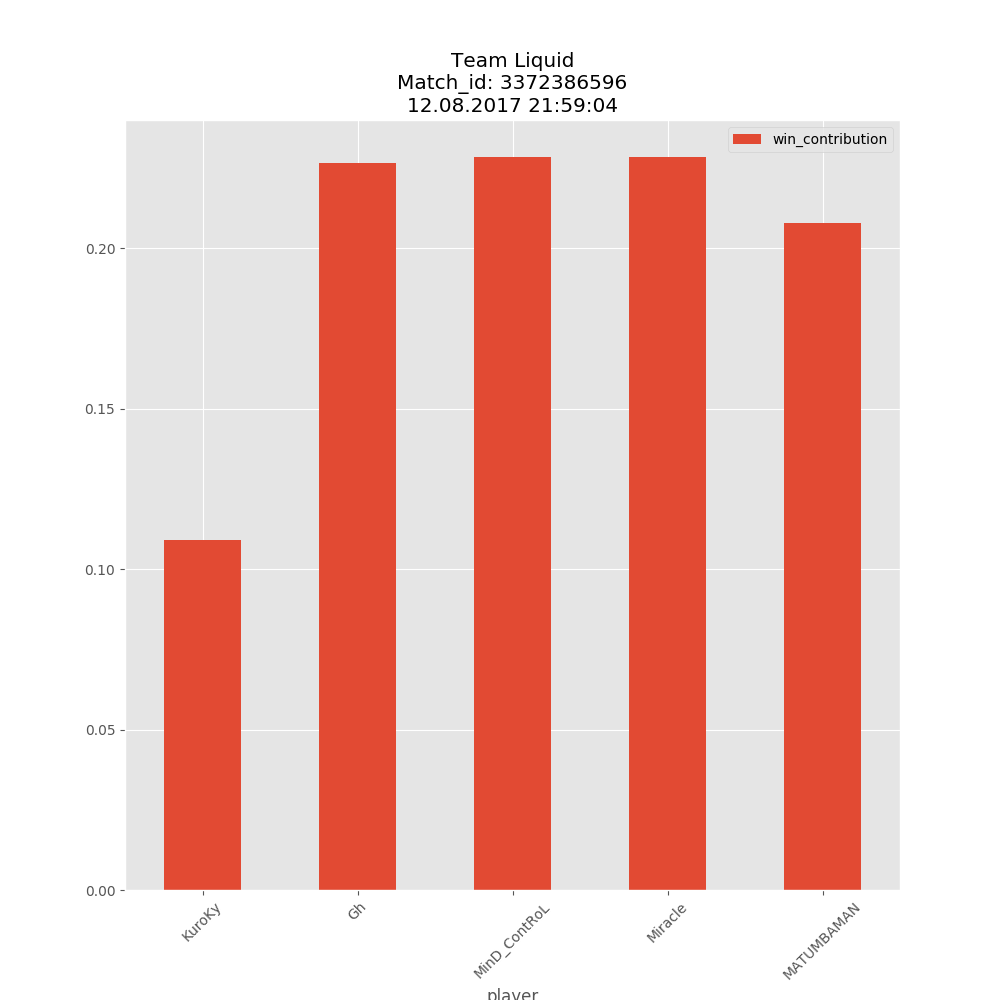

<IPython.core.display.Javascript object>


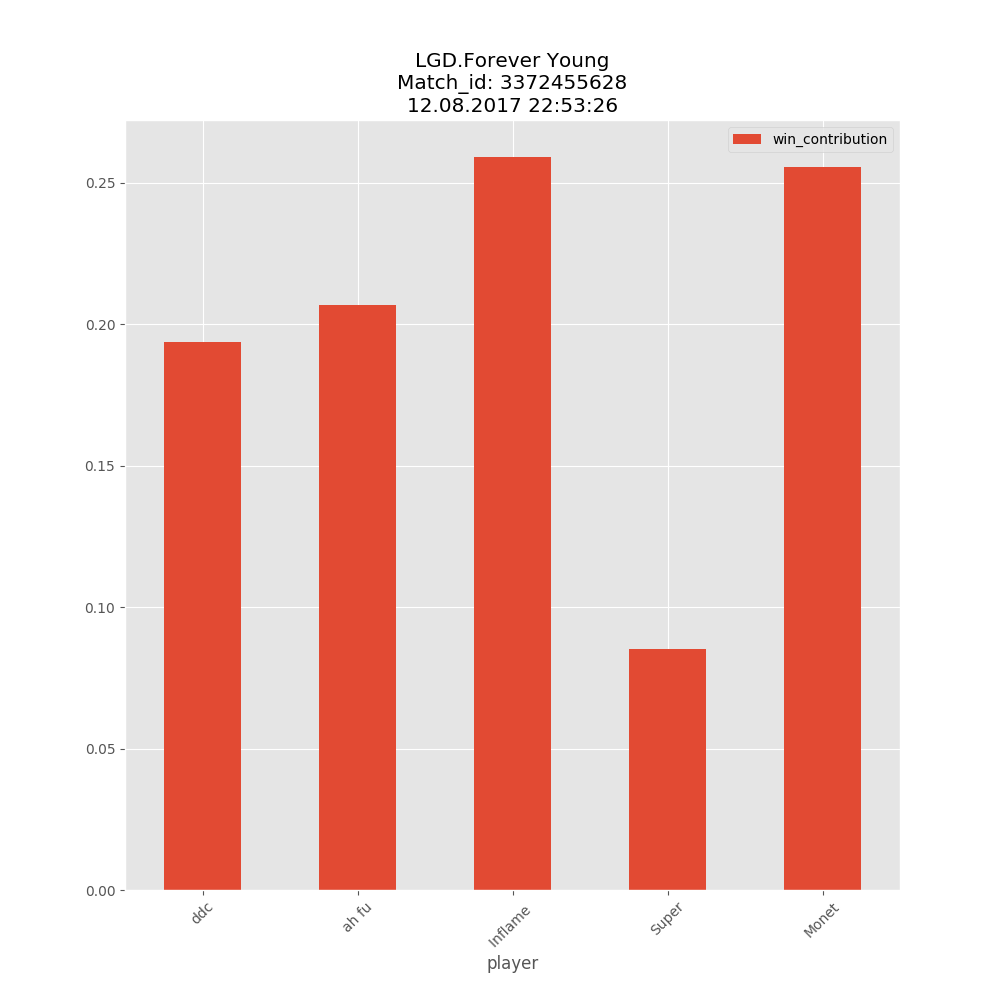

<IPython.core.display.Javascript object>


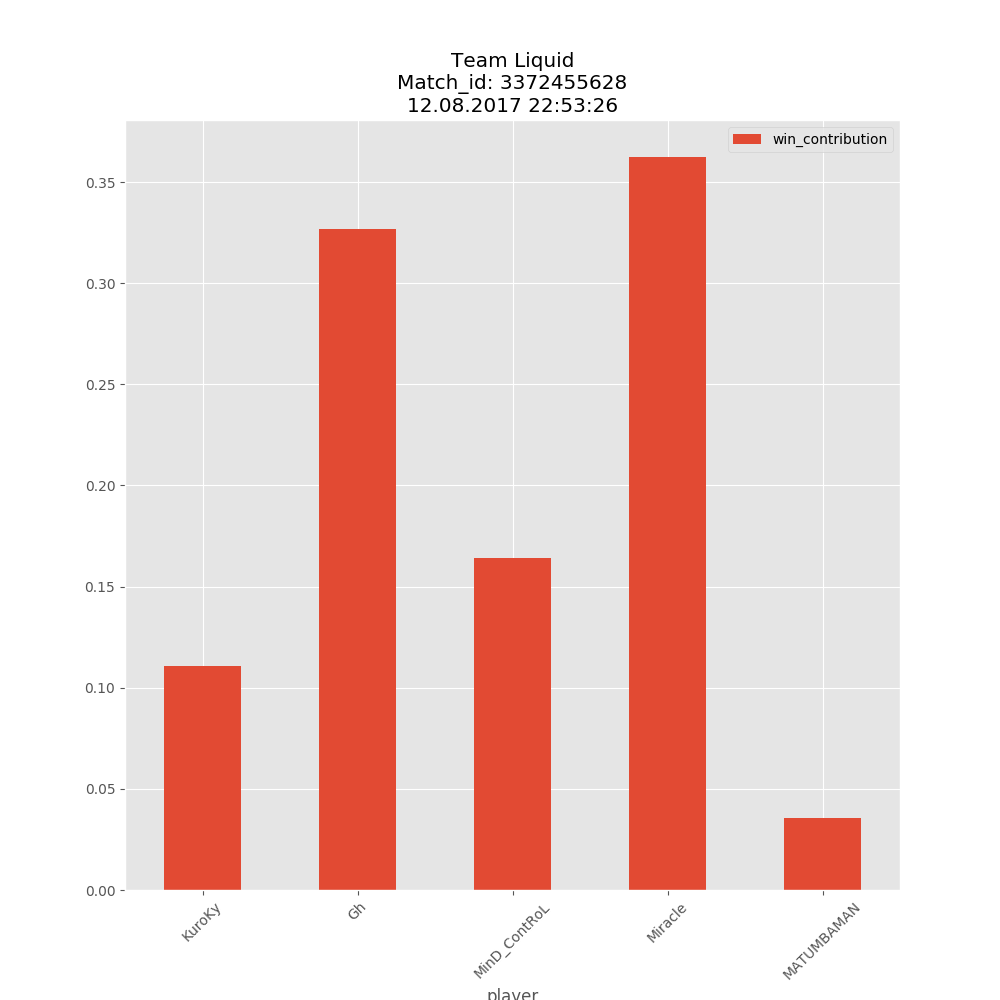

<IPython.core.display.Javascript object>


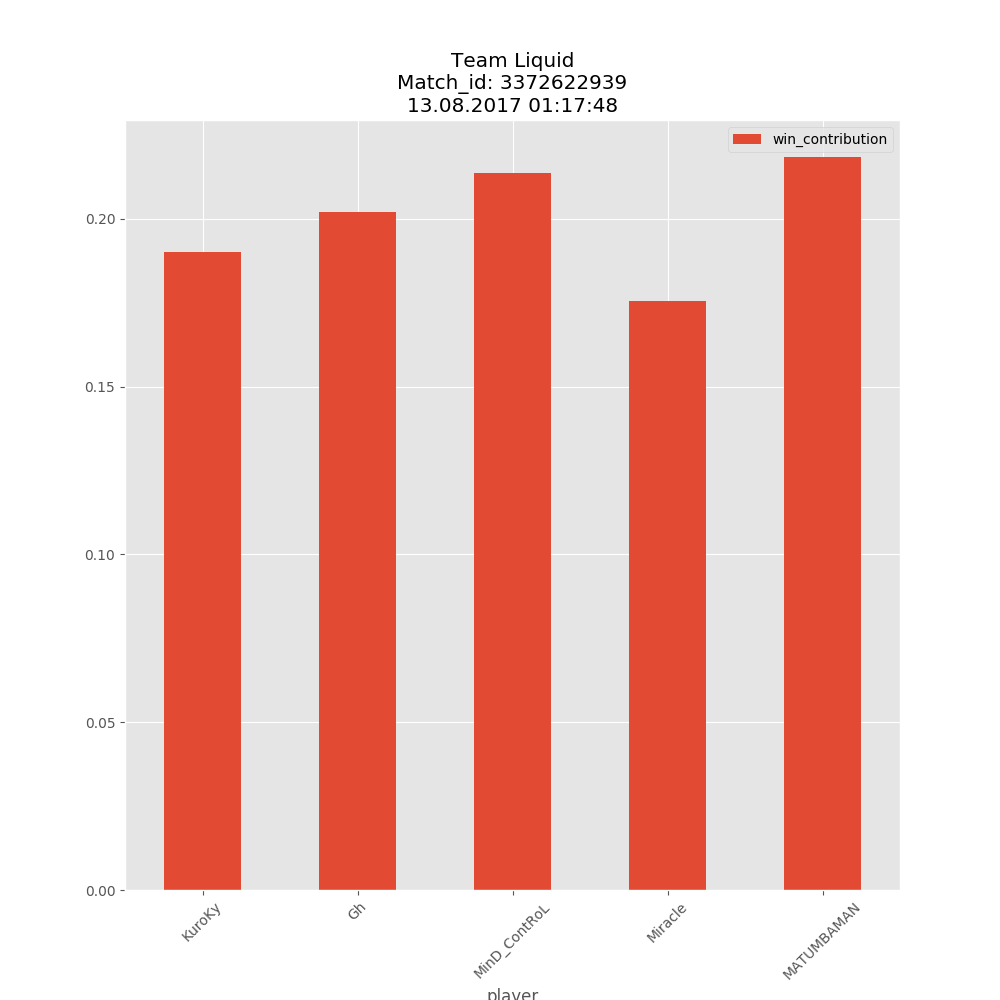

<IPython.core.display.Javascript object>


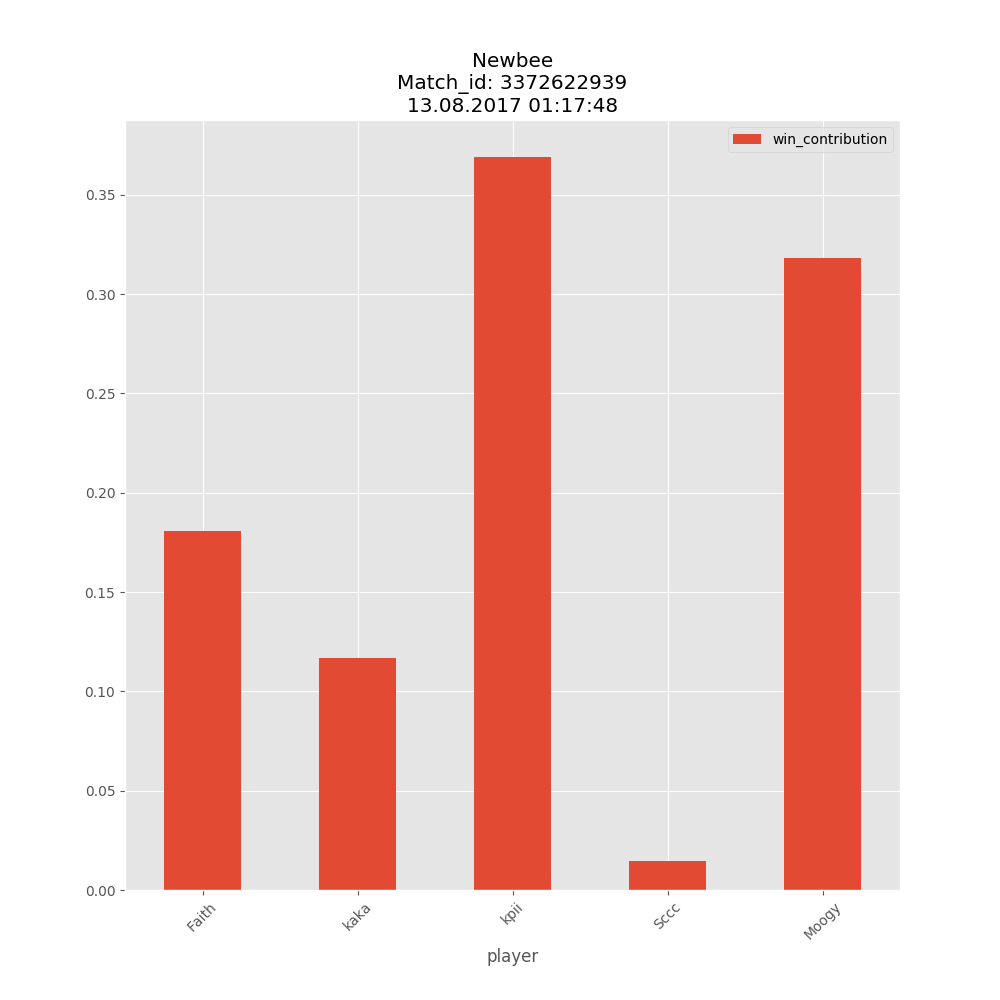

<IPython.core.display.Javascript object>


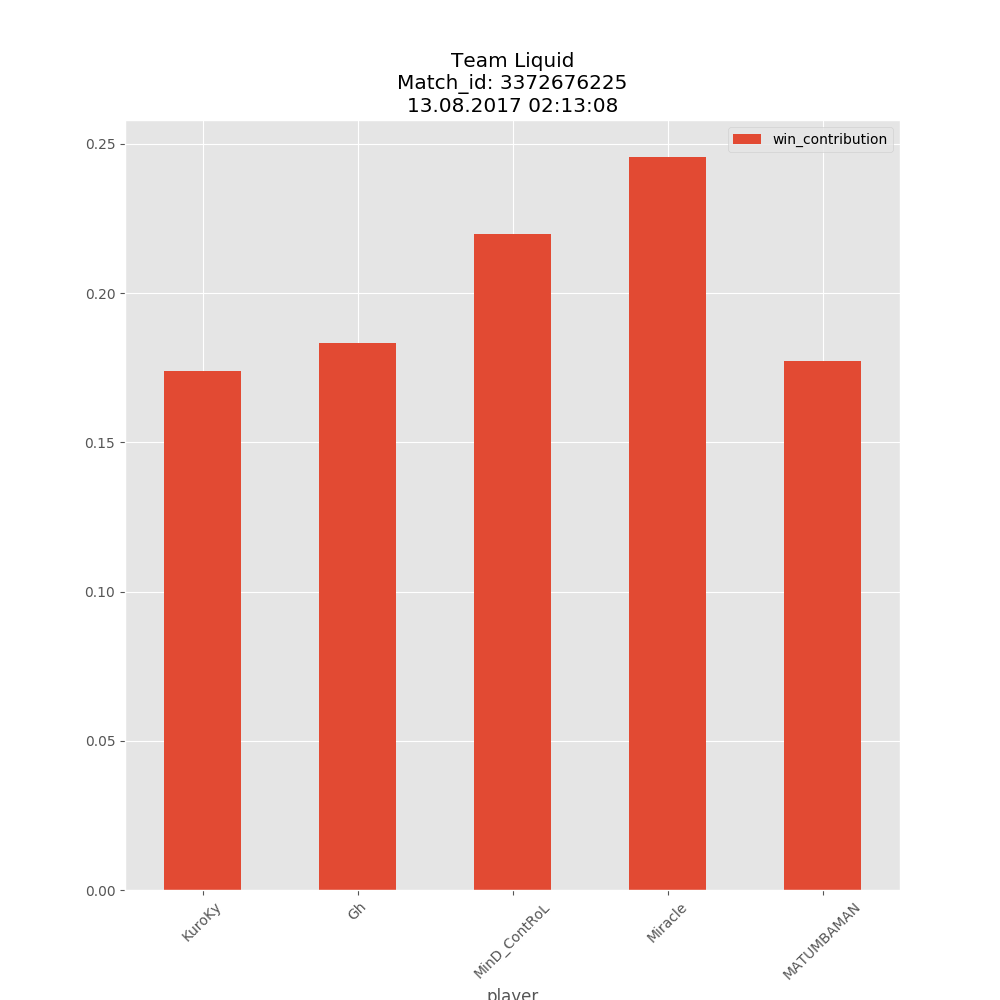

<IPython.core.display.Javascript object>


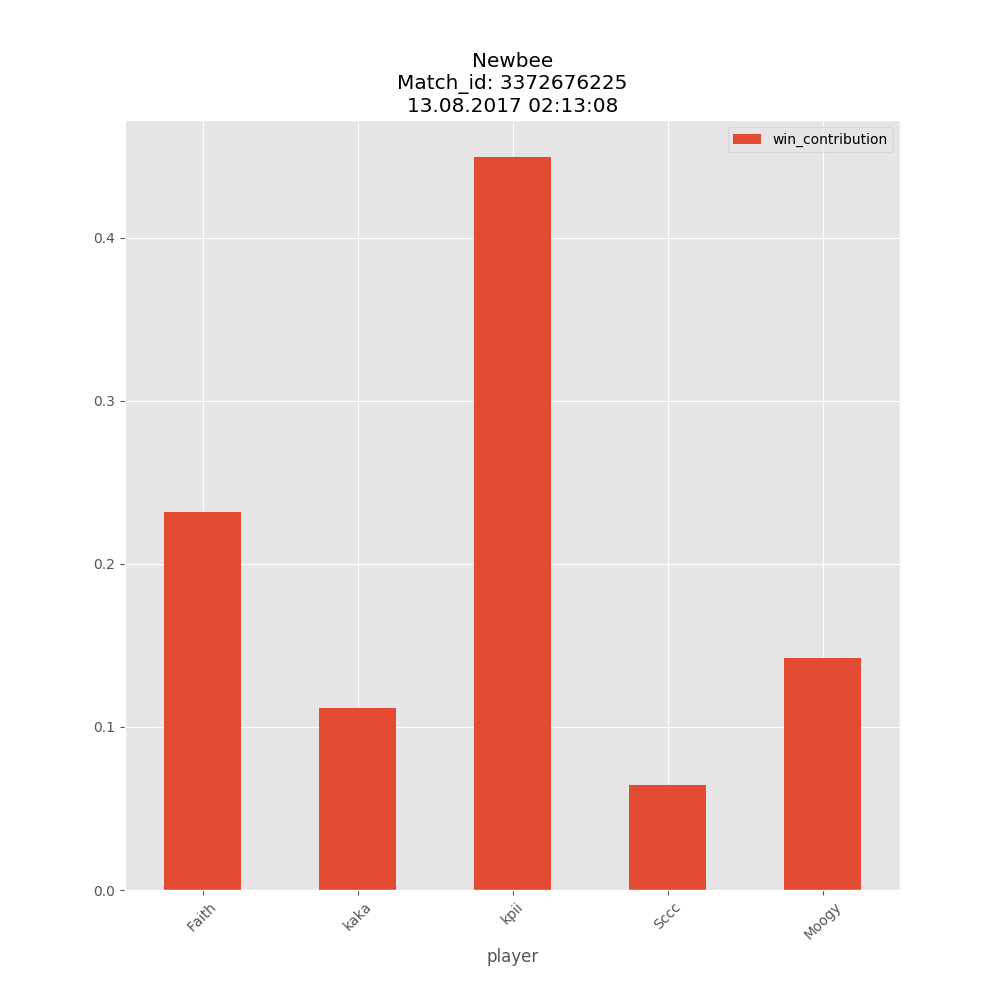

<IPython.core.display.Javascript object>


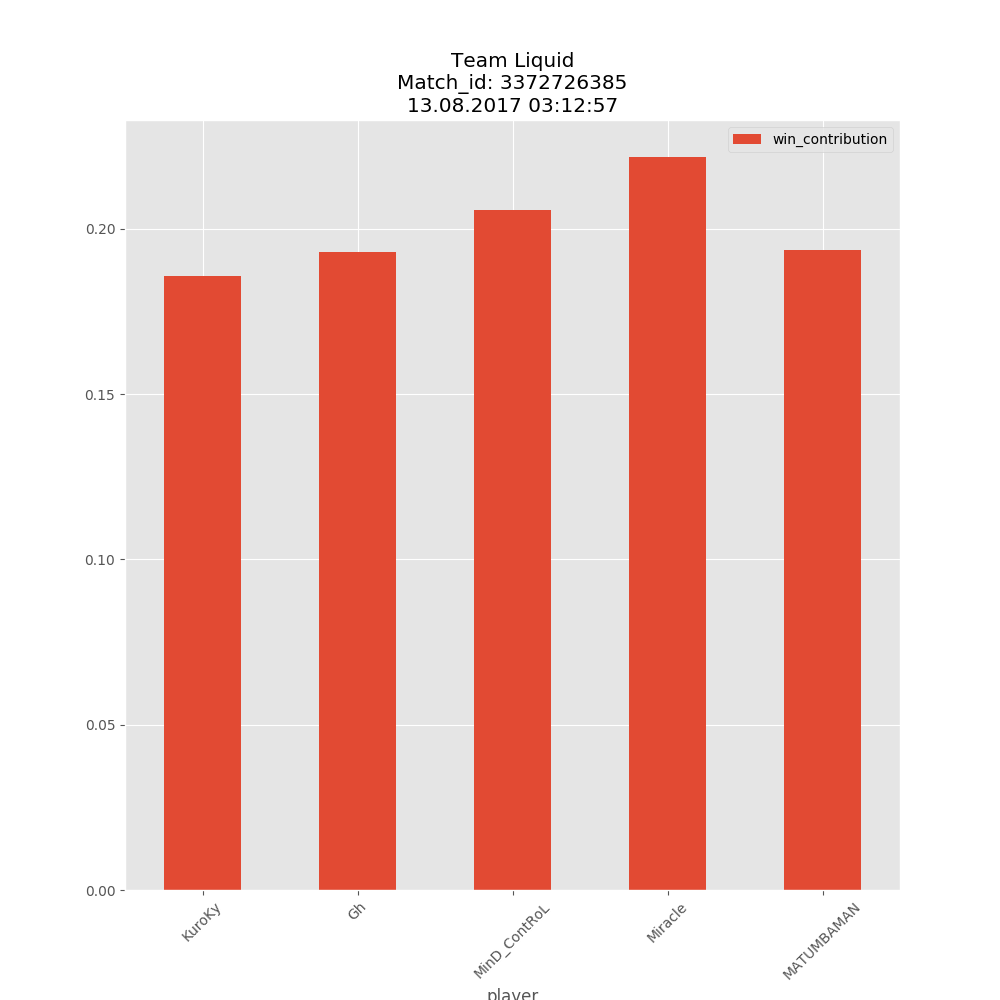

<IPython.core.display.Javascript object>


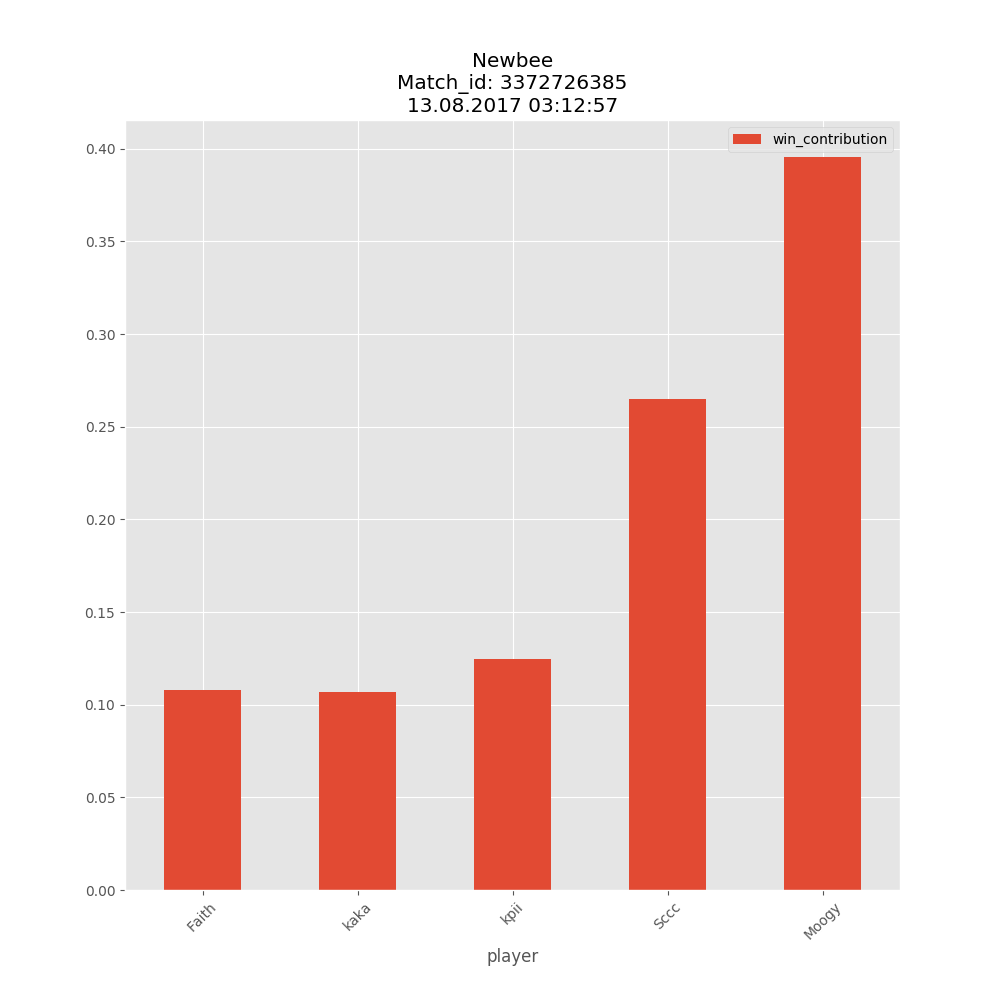

In [147]:
# match_id = 3368158118
for match_id in ti_main:
    match_id = str(match_id)   
    for team_id in sMatches[sMatches.match_id == match_id].team_id.unique().tolist():  
        fig = plt.figure(figsize=(10,10))
        fig.add_axes()
        ax = fig.add_subplot(111)
        team_id = str(float(team_id))
        example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
        info = player_role[player_role['account_id'].isin(example.account_id.tolist())]
        info = player_role[player_role['account_id'].isin(example.account_id.tolist())]
        info['role'] = info.role.astype('float').astype('str')
        example = pd.merge(example, info, on='role')
    #     display(example)
        picTitle = info.team.values[0] + "\nMatch_id: " + str(example.iloc[0,1] + '\n' + example.datetime.values[0])
        plot = example.plot(kind='bar', x = 'player', y = 'win_contribution', title = picTitle, rot=45, ax=ax)
        fig.savefig(str(example.iloc[0,1]) + "_" + info.team.values[0] + ".png", dpi = 400)
    #     plt.show()

In [78]:
example.iloc[0,1]

'3368158118'

In [25]:
l = []
for match_id in ti_main:
    match_id = str(match_id)   
    for team_id in sMatches[sMatches.match_id == match_id].team_id.unique().tolist():  
        team_id = str(float(team_id))
        example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
        info = player_role[player_role['account_id'].isin(example.account_id.tolist())]
        info = player_role[player_role['account_id'].isin(example.account_id.tolist())]
        info['role'] = info.role.astype('float').astype('str')
        example = pd.merge(example, info, on='role')
        l.append(example.groupby('match_id', as_index=False).first()[['match_id', 'account_id_x', 'team', 'team_id', 'datetime']])
pd.concat(l).to_csv('participants.csv')